In [2]:
import pandas as pd
import numpy as np
import re
import io
import os

# 调试代码（不执行）

In [9]:
def is_int_token(t: str) -> bool:
    """检查一个 token 是否是纯数字（可能带空格）"""
    return t.strip().isdigit()

# 您的文件路径
path = "/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/p01-r1_Tobii Pro Fusion_20250925203611/p01-r1_P01-A[自定义类型](391-753)/GazeData(Absolute).csv"

try:
    # 1) 找到 “Gaze Data”
    with open(path, "r", encoding="utf-8-sig") as f:
        lines = f.readlines()

    start = None
    for i, line in enumerate(lines):
        # if line.strip() == "End Time(s)":
        #     start = i
        #     break
        start = 7    
    if start is None:
        print("错误：未找到 'Gaze Data' 锚点。脚本停止。")
    else:
        print(f"✅ 成功找到 'Gaze Data' 锚点于第 {start} 行。")

        # 2) 表头与数据
        header = lines[start + 1].strip()
        
        # 【修改点】只取数据区的前10行
        data_lines = lines[start + 2 : start + 2 + 10]
        
        print(f"\n表头 (Header): \n{header}\n")
        print(f"---- 准备处理 {len(data_lines)} 行数据 (最多10行) ----\n")

        fixed_lines = [header]

        for line_index, ln in enumerate(data_lines):
            ln = ln.strip()
            
            print(f"--- 正在处理第 {line_index+1} 行 (原始文件第 {start + 2 + line_index}) ---")
            print(f"原始行 (Original): {ln}")

            if not ln:
                print("  结果：空行，已跳过。\n")
                continue

            # 仅切出前两个字段：Id, Time
            parts = ln.split(',', 2)
            if len(parts) < 3:
                print("  ⚠️ 警告：此行无法被 split(',', 2) 分割为3部分，已跳过。\n")
                continue
                
            id_field   = parts[0].strip()
            time_field = parts[1].strip()
            rest       = parts[2]
            
            print(f"  Id (part 0):   {id_field}")
            print(f"  Time (part 1): {time_field}")
            print(f"  Rest (part 2): {rest}")

            tokens = [t.strip() for t in rest.split(',')]
            print(f"  Tokens:        {tokens}")

            # 期望列顺序：
            # X(%), Y(%), X(px), Y(px), Eye State, Velocity(degree/s)
            numeric_fields = []
            
            # 【修改点】增加一个标志位，用于清晰地打印跳过原因
            skip_this_line = False
            
            idx = 0
            # 先组合4个数值列（每列由两个整数token组成）
            for field_num in range(4): # 循环4次 (X%, Y%, Xpx, Ypx)
                if idx + 1 < len(tokens) and is_int_token(tokens[idx]) and is_int_token(tokens[idx + 1]):
                    combined_val = tokens[idx] + "." + tokens[idx + 1]
                    numeric_fields.append(combined_val)
                    print(f"    - 组合字段 {field_num+1}: {tokens[idx]} + {tokens[idx+1]} -> {combined_val}")
                    idx += 2
                else:
                    print(f"    ⚠️ 错误：组合字段 {field_num+1} 时出错。")
                    if not idx + 1 < len(tokens):
                         print("       原因：Tokens 列表长度不足。")
                    elif not is_int_token(tokens[idx]):
                         print(f"       原因：Token '{tokens[idx]}' 不是整数。")
                    elif not is_int_token(tokens[idx+1]):
                         print(f"       原因：Token '{tokens[idx+1]}' 不是整数。")
                    numeric_fields.append(None) # 添加一个 None 占位
                    skip_this_line = True
                    break # 中断 for 循环

            # 找 Eye State（第一个非纯数字 token）
            eye_state = None
            if not skip_this_line: # 如果前面已经出错了，就不用继续了
                if idx < len(tokens):
                    if not is_int_token(tokens[idx]):  # 眼动状态是中文
                        eye_state = tokens[idx]
                        print(f"    - 找到 Eye State: {eye_state}")
                        idx += 1
                    else:
                        print(f"    ⚠️ 错误：期望 Eye State (非数字)，但找到 '{tokens[idx]}'")
                        skip_this_line = True
                else:
                    print("    ⚠️ 错误：Tokens 列表长度不足，无法找到 Eye State。")
                    skip_this_line = True

            # 组合最终的速度值
            velocity = None
            if not skip_this_line: # 如果前面已经出错了，就不用继续了
                if idx + 1 < len(tokens) and is_int_token(tokens[idx]) and is_int_token(tokens[idx + 1]):
                    velocity = tokens[idx] + "." + tokens[idx + 1]
                    print(f"    - 组合 Velocity: {tokens[idx]} + {tokens[idx+1]} -> {velocity}")
                    idx += 2
                else:
                    print("    ⚠️ 错误：组合 Velocity 时出错。")
                    if not idx + 1 < len(tokens):
                         print("       原因：Tokens 列表长度不足。")
                    elif not is_int_token(tokens[idx]):
                         print(f"       原因：Token '{tokens[idx]}' 不是整数。")
                    elif not is_int_token(tokens[idx+1]):
                         print(f"       原因：Token '{tokens[idx+1]}' 不是整数。")
                    skip_this_line = True

            # 防御：若关键列缺失，放弃该行
            # (您的原始检查)
            if skip_this_line or any(v is None for v in numeric_fields) or (eye_state is None) or (velocity is None):
                print(f"  结果：跳过该行 (数据格式不匹配)。\n")
                continue

            # 拼回一行：严格用英文逗号分隔字段
            new_line_parts = [
                id_field,
                time_field,
                numeric_fields[0],  # X(%)
                numeric_fields[1],  # Y(%)
                numeric_fields[2],  # X(px)
                numeric_fields[3],  # Y(px)
                eye_state,            # Eye State (中文)
                velocity              # Velocity(degree/s)
            ]
            new_line = ",".join(new_line_parts)
            print(f"  最终行 (New Line): {new_line}\n")
            fixed_lines.append(new_line)

        # 4) 转成文本喂给 pandas
        print("---- 最终生成的 CSV 文本 (共 {len(fixed_lines)} 行) ----")
        csv_text = "\n".join(fixed_lines)
        print(csv_text)
        print("--------------------------------------\n")
        
        df = pd.read_csv(io.StringIO(csv_text), sep=",", engine="python", encoding="utf-8-sig")

        # 5) 数值化
        print("---- 尝试将列转换为数值型 ----")
        for col in ["X(%)", "Y(%)", "X(px)", "Y(px)", "Velocity(degree/s)"]:
            if col in df.columns:
                print(f"转换列: {col}")
                try:
                    df[col] = pd.to_numeric(df[col], errors="coerce")
                except Exception as e:
                    print(f"❌ 转换列 {col} 时出错: {e}")

        print("\n---- ✅ 成功读取 DataFrame (最多10行) ----")
        print(df.head(10)) # 打印前10行
        
        print("\n---- DataFrame 信息 (dtypes) ----")
        df.info() # df.info() 包含 dtypes，信息更全

except FileNotFoundError:
    print(f"❌ 错误：文件未找到，请检查路径是否正确。\n路径: {path}")
except Exception as e:
    print(f"❌ 发生了一个意外错误: {e}")

✅ 成功找到 'Gaze Data' 锚点于第 7 行。

表头 (Header): 
Id,Time,X(%),Y(%),X(px),Y(px),Eye State Type,Velocity(degree/s)

---- 准备处理 10 行数据 (最多10行) ----

--- 正在处理第 1 行 (原始文件第 9) ---
原始行 (Original): 1,2025-07-22 13:48:29.582,31,3303169986558,54,3332460853789,601,542086374192,586,799057722092,注视,13,902882796492
  Id (part 0):   1
  Time (part 1): 2025-07-22 13:48:29.582
  Rest (part 2): 31,3303169986558,54,3332460853789,601,542086374192,586,799057722092,注视,13,902882796492
  Tokens:        ['31', '3303169986558', '54', '3332460853789', '601', '542086374192', '586', '799057722092', '注视', '13', '902882796492']
    - 组合字段 1: 31 + 3303169986558 -> 31.3303169986558
    - 组合字段 2: 54 + 3332460853789 -> 54.3332460853789
    - 组合字段 3: 601 + 542086374192 -> 601.542086374192
    - 组合字段 4: 586 + 799057722092 -> 586.799057722092
    - 找到 Eye State: 注视
    - 组合 Velocity: 13 + 902882796492 -> 13.902882796492
  最终行 (New Line): 1,2025-07-22 13:48:29.582,31.3303169986558,54.3332460853789,601.542086374192,586.79905772209

In [10]:
path = "/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/p01-r1_Tobii Pro Fusion_20250925203611/p01-r1_P01-A[自定义类型](391-753)/PupilData(Absolute).csv"
def is_int_token(t: str) -> bool:
    """检查一个 token 是否是纯数字（可能带空格）"""
    return t.strip().isdigit()
try:
    # 1) 找到 “Pupil Data”
    with open(path, "r", encoding="utf-8-sig") as f:
        lines = f.readlines()

    start = None
    for i, line in enumerate(lines):
        if line.strip() == "Pupil Data":
            start = i
            break
    if start is None:
        print("错误：未找到 'Pupil Data' 锚点。脚本停止。")
    else:
        print(f"✅ 成功找到 'Pupil Data' 锚点于第 {start} 行。")

        # 2) 表头与数据
        header = lines[start + 1].strip()
        
        # 【修改点】只取数据区的前10行
        data_lines = lines[start + 2 : start + 2 + 10]
        
        print(f"\n表头 (Header): \n{header}\n")
        print(f"---- 准备处理 {len(data_lines)} 行数据 (最多10行) ----\n")

        fixed_lines = [header]

        for line_index, ln in enumerate(data_lines):
            ln = ln.strip()
            
            print(f"--- 正在处理第 {line_index+1} 行 (原始文件第 {start + 2 + line_index}) ---")
            print(f"原始行 (Original): {ln}")

            if not ln:
                print("  结果：空行，已跳过。\n")
                continue

            # 仅切出前两个字段：Id, Time
            parts = ln.split(',', 2)
            if len(parts) < 3:
                print("  ⚠️ 警告：此行无法被 split(',', 2) 分割为3部分，已跳过。\n")
                continue
                
            id_field   = parts[0].strip()
            time_field = parts[1].strip()
            rest       = parts[2]
            
            print(f"  Id (part 0):   {id_field}")
            print(f"  Time (part 1): {time_field}")
            print(f"  Rest (part 2): {rest}")

            tokens = [t.strip() for t in rest.split(',')]
            print(f"  Tokens:        {tokens}")

            # 期望列顺序：
            # X(%), Y(%), X(px), Y(px), Eye State, Velocity(degree/s)
            numeric_fields = []
            
            # 【修改点】增加一个标志位，用于清晰地打印跳过原因
            skip_this_line = False
            
            idx = 0
            # 先组合4个数值列（每列由两个整数token组成）
            for field_num in range(9): # 循环4次 (X%, Y%, Xpx, Ypx)
                if idx + 1 < len(tokens) and is_int_token(tokens[idx]) and is_int_token(tokens[idx + 1]):
                    combined_val = tokens[idx] + "." + tokens[idx + 1]
                    numeric_fields.append(combined_val)
                    print(f"    - 组合字段 {field_num+1}: {tokens[idx]} + {tokens[idx+1]} -> {combined_val}")
                    idx += 2
                else:
                    print(f"    ⚠️ 错误：组合字段 {field_num+1} 时出错。")
                    if not idx + 1 < len(tokens):
                         print("       原因：Tokens 列表长度不足。")
                    elif not is_int_token(tokens[idx]):
                         print(f"       原因：Token '{tokens[idx]}' 不是整数。")
                    elif not is_int_token(tokens[idx+1]):
                         print(f"       原因：Token '{tokens[idx+1]}' 不是整数。")
                    numeric_fields.append(None) # 添加一个 None 占位
                    skip_this_line = True
                    break # 中断 for 循环


            # 防御：若关键列缺失，放弃该行
            # (您的原始检查)
            if skip_this_line or any(v is None for v in numeric_fields) :
                print(f"  结果：跳过该行 (数据格式不匹配)。\n")
                continue

            # 拼回一行：严格用英文逗号分隔字段
            new_line_parts = [
                id_field,
                time_field,
                numeric_fields[0],  
                numeric_fields[1],  
                numeric_fields[2],  
                numeric_fields[3],  
                numeric_fields[4],
                numeric_fields[5],
                numeric_fields[6],
                numeric_fields[7],
                numeric_fields[8]
            ]
            new_line = ",".join(new_line_parts)
            print(f"  最终行 (New Line): {new_line}\n")
            fixed_lines.append(new_line)

        # 4) 转成文本喂给 pandas
        print("---- 最终生成的 CSV 文本 (共 {len(fixed_lines)} 行) ----")
        csv_text = "\n".join(fixed_lines)
        print(csv_text)
        print("--------------------------------------\n")
        
        df = pd.read_csv(io.StringIO(csv_text), sep=",", engine="python", encoding="utf-8-sig")

        # 5) 数值化
        print("---- 尝试将列转换为数值型 ----")
        for col in ["LeftPupilDiameter(mm)", "RightPupilDiameter(mm)", "AveragePupilDiameter(mm)", 
                    "LeftPupilRadius(mm)", "RightPupilRadius(mm)", "AveragePupilRadius(mm)", 
                    "LeftPupilArea(mm²)", "RightPupilArea(mm²)", "AveragePupilArea(mm²)"]:
            if col in df.columns:
                print(f"转换列: {col}")
                try:
                    df[col] = pd.to_numeric(df[col], errors="coerce")
                except Exception as e:
                    print(f"❌ 转换列 {col} 时出错: {e}")

        print("\n---- ✅ 成功读取 DataFrame (最多10行) ----")
        print(df.head(10)) # 打印前10行
        
        print("\n---- DataFrame 信息 (dtypes) ----")
        df.info() # df.info() 包含 dtypes，信息更全

except FileNotFoundError:
    print(f"❌ 错误：文件未找到，请检查路径是否正确。\n路径: {path}")
except Exception as e:
    print(f"❌ 发生了一个意外错误: {e}")

✅ 成功找到 'Pupil Data' 锚点于第 16 行。

表头 (Header): 
Id,Time,LeftPupilDiameter(mm),RightPupilDiameter(mm),AveragePupilDiameter(mm),LeftPupilRadius(mm),RightPupilRadius(mm),AveragePupilRadius(mm),LeftPupilArea(mm²),RightPupilArea(mm²),AveragePupilArea(mm²)

---- 准备处理 10 行数据 (最多10行) ----

--- 正在处理第 1 行 (原始文件第 18) ---
原始行 (Original): 1,2025-07-22 13:48:29.582,3,84014892578125,3,98231506347656,3,91123199462891,1,92007446289063,1,99115753173828,1,95561599731445,11,5820654747621,12,4554985197943,12,0148135353358
  Id (part 0):   1
  Time (part 1): 2025-07-22 13:48:29.582
  Rest (part 2): 3,84014892578125,3,98231506347656,3,91123199462891,1,92007446289063,1,99115753173828,1,95561599731445,11,5820654747621,12,4554985197943,12,0148135353358
  Tokens:        ['3', '84014892578125', '3', '98231506347656', '3', '91123199462891', '1', '92007446289063', '1', '99115753173828', '1', '95561599731445', '11', '5820654747621', '12', '4554985197943', '12', '0148135353358']
    - 组合字段 1: 3 + 84014892578125 -> 3.84

# 眼动数据预处理

## 处理逗号问题

### 函数-fixation


In [4]:
def load_tobii_fixation_csv(path: str) -> pd.DataFrame:
    """读取 Tobii 导出的 FixationData(Absolute).csv 文件，
    自动处理头部信息和数字小数点逗号问题。"""

    # 找到 “Gaze Data” 锚点
    with open(path, "r", encoding="utf-8-sig") as f:
        lines = f.readlines()

    start = None
    for i, line in enumerate(lines):
        if line.strip() == "Gaze Data":
            start = i
            break
    if start is None:
        raise ValueError("未找到 'Gaze Data' 锚点。")

    # 表头与数据
    header = lines[start + 1].strip()
    data_lines = lines[start + 2:]

    def is_int_token(t: str) -> bool:
        return t.strip().isdigit()

    fixed_lines = [header]

    for ln in data_lines:
        ln = ln.strip()
        if not ln:
            continue

        parts = ln.split(',', 2)
        if len(parts) < 3:
            continue

        id_field = parts[0].strip()
        time_field = parts[1].strip()
        rest = parts[2]
        tokens = [t.strip() for t in rest.split(',')]

        numeric_fields = []
        idx = 0
        # 组合四个数值列
        for _ in range(4):
            if idx + 1 < len(tokens) and is_int_token(tokens[idx]) and is_int_token(tokens[idx + 1]):
                numeric_fields.append(tokens[idx] + "." + tokens[idx + 1])
                idx += 2
            else:
                numeric_fields.append(None)
                break

        # Eye State
        eye_state = None
        if idx < len(tokens):
            if not is_int_token(tokens[idx]):
                eye_state = tokens[idx]
                idx += 1

        # Velocity
        velocity = None
        if idx + 1 < len(tokens) and is_int_token(tokens[idx]) and is_int_token(tokens[idx + 1]):
            velocity = tokens[idx] + "." + tokens[idx + 1]

        if any(v is None for v in numeric_fields) or eye_state is None or velocity is None:
            continue

        new_line = ",".join([
            id_field, time_field,
            numeric_fields[0], numeric_fields[1],
            numeric_fields[2], numeric_fields[3],
            eye_state, velocity
        ])
        fixed_lines.append(new_line)

    csv_text = "\n".join(fixed_lines)
    df = pd.read_csv(io.StringIO(csv_text), sep=",", engine="python", encoding="utf-8-sig")

    # 转换数值列
    for col in ["X(%)", "Y(%)", "X(px)", "Y(px)", "Velocity(degree/s)"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    print(f"成功读取 DataFrame，行数: {len(df)}")
    return df


### 文件执行-fixation

In [7]:
root_dir = "/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动"
output_dir = os.path.join(root_dir, "汇总_FixationData_cleaned")
os.makedirs(output_dir, exist_ok=True)

# 递归搜索所有 FixationData(Absolute).csv 文件
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file == "FixationData(Absolute).csv":
            file_path = os.path.join(root, file)

            # 从路径中提取被试编号 Pxx 和 block（A–H）
            match_p = re.search(r"P(\d+)", file_path)
            match_block = re.search(r"-([A-H])(\b|[^A-Za-z])", file_path)

            participant_id = f"P{match_p.group(1)}" if match_p else "Unknown"
            block_label = match_block.group(1) if match_block else "full"

            print(f"🟦 正在处理 {participant_id} - Block {block_label} ...")

            try:
                # 调用你之前定义的清洗函数
                df = load_tobii_fixation_csv(file_path)

                # 添加元信息列（可选）
                df["participant_id"] = participant_id
                df["block_label"] = block_label

                # 保存为新的 CSV
                clean_name = f"{participant_id}_Block-{block_label}_Fixation_clean.csv"
                out_path = os.path.join(output_dir, clean_name)
                df.to_csv(out_path, index=False, encoding="utf-8-sig")

                print(f"✅ 已保存：{out_path}")

            except Exception as e:
                print(f"❌ {file_path} 处理失败：{e}")

print(f"\n🎯 所有 FixationData(Absolute).csv 已清洗并保存至：{output_dir}")


🟦 正在处理 P01 - Block A ...
成功读取 DataFrame，行数: 84094
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_FixationData_cleaned/P01_Block-A_Fixation_clean.csv
🟦 正在处理 P01 - Block B ...
成功读取 DataFrame，行数: 89036
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_FixationData_cleaned/P01_Block-B_Fixation_clean.csv
🟦 正在处理 Unknown - Block full ...
成功读取 DataFrame，行数: 223789
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_FixationData_cleaned/Unknown_Block-full_Fixation_clean.csv
🟦 正在处理 P01 - Block C ...
成功读取 DataFrame，行数: 87317
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_FixationData_cleaned/P01_Block-C_Fixation_clean.csv
🟦 正在处理 P01 - Block H ...
成功读取 DataFrame，行数: 166980
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_FixationData_cleaned/P01_Block-H_Fixation_clean.csv
🟦 正在处理 Unknown - Block full ...
成功读取 DataFrame，行数: 273380
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_FixationData_cleaned/Unknown_Block-full_Fixation_clean.csv
🟦 正在处理 P01 - Bl

### 函数-Gaze

In [3]:
def load_tobii_gaze_csv(path: str) -> pd.DataFrame:

    # 找到 “Gaze Data” 锚点
    with open(path, "r", encoding="utf-8-sig") as f:
        lines = f.readlines()

    start = 7

    # 表头与数据
    header = lines[start + 1].strip()
    data_lines = lines[start + 2:]

    def is_int_token(t: str) -> bool:
        return t.strip().isdigit()

    fixed_lines = [header]

    for ln in data_lines:
        ln = ln.strip()
        if not ln:
            continue

        parts = ln.split(',', 2)
        if len(parts) < 3:
            continue

        id_field = parts[0].strip()
        time_field = parts[1].strip()
        rest = parts[2]
        tokens = [t.strip() for t in rest.split(',')]

        numeric_fields = []
        idx = 0
        # 组合四个数值列
        for _ in range(4):
            if idx + 1 < len(tokens) and is_int_token(tokens[idx]) and is_int_token(tokens[idx + 1]):
                numeric_fields.append(tokens[idx] + "." + tokens[idx + 1])
                idx += 2
            else:
                numeric_fields.append(None)
                break

        # Eye State
        eye_state = None
        if idx < len(tokens):
            if not is_int_token(tokens[idx]):
                eye_state = tokens[idx]
                idx += 1

        # Velocity
        velocity = None
        if idx + 1 < len(tokens) and is_int_token(tokens[idx]) and is_int_token(tokens[idx + 1]):
            velocity = tokens[idx] + "." + tokens[idx + 1]

        if any(v is None for v in numeric_fields) or eye_state is None or velocity is None:
            continue

        new_line = ",".join([
            id_field, time_field,
            numeric_fields[0], numeric_fields[1],
            numeric_fields[2], numeric_fields[3],
            eye_state, velocity
        ])
        fixed_lines.append(new_line)

    csv_text = "\n".join(fixed_lines)
    df = pd.read_csv(io.StringIO(csv_text), sep=",", engine="python", encoding="utf-8-sig")

    # 转换数值列
    for col in ["X(%)", "Y(%)", "X(px)", "Y(px)", "Velocity(degree/s)"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    print(f"成功读取 DataFrame，行数: {len(df)}")
    return df


In [14]:
path = "/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/p01-r1_Tobii Pro Fusion_20250925203611/p01-r1_P01-A[自定义类型](391-753)/GazeData(Absolute).csv"
load_tobii_gaze_csv(path)

成功读取 DataFrame，行数: 84094


Id                     Time       X(%)       Y(%)        X(px)  \
0          1  2025-07-22 13:48:29.582  31.330317  54.333246   601.542086   
1          2  2025-07-22 13:48:29.586  31.330317  54.333246   601.542086   
2          3  2025-07-22 13:48:29.590  31.330317  54.333246   601.542086   
3          4  2025-07-22 13:48:29.594  31.330317  54.333246   601.542086   
4          5  2025-07-22 13:48:29.598  31.330317  54.333246   601.542086   
...      ...                      ...        ...        ...          ...   
84089  90496  2025-07-22 13:54:31.562  54.825917  34.751639  1052.657601   
84090  90497  2025-07-22 13:54:31.566  54.825917  34.751639  1052.657601   
84091  90498  2025-07-22 13:54:31.570  54.825917  34.751639  1052.657601   
84092  90499  2025-07-22 13:54:31.574  54.825917  34.751639  1052.657601   
84093  90500  2025-07-22 13:54:31.578  54.825917  34.751639  1052.657601   

            Y(px) Eye State Type  Velocity(degree/s)  
0      586.799058             注视           13.902883  
1      586.799058             注视           12.279990  
2      586.799058             注视           13.273342  
3      586.799058             注视           18.013248  
4      586.799058             注视           15.291296  
...           ...            ...                 ...  
84089  375.317705             注视            6.319389  
84090  375.317705             注视            5.230399  
84091  375.317705             注视            3.161941  
84092  375.317705             注视            7.017652  
84093  375.317705             注视            5.374719  

[84094 rows x 8 columns]

### 文件执行-gaze

In [4]:
root_dir = "/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动"
output_dir = os.path.join(root_dir, "汇总_GazeData_cleaned")
os.makedirs(output_dir, exist_ok=True)

# 递归搜索所有 GazeData(Absolute).csv 文件
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file == "GazeData(Absolute).csv":
            file_path = os.path.join(root, file)

            # 从路径中提取被试编号 Pxx 和 block（A–H）
            match_p = re.search(r"P(\d+)", file_path)
            match_block = re.search(r"-([A-H])(\b|[^A-Za-z])", file_path)

            participant_id = f"{match_p.group(1)}" if match_p else "Unknown"
            block_label = match_block.group(1) if match_block else "full"

            print(f"🟦 正在处理 {participant_id} - Block {block_label} ...")

            try:
                # 调用你之前定义的清洗函数
                df = load_tobii_gaze_csv(file_path)

                # 添加元信息列（可选）
                df["participant_id"] = participant_id
                df["block_label"] = block_label

                # 保存为新的 CSV
                clean_name = f"{participant_id}_Block-{block_label}_Gaze_clean.csv"
                out_path = os.path.join(output_dir, clean_name)
                df.to_csv(out_path, index=False, encoding="utf-8-sig")

                print(f"✅ 已保存：{out_path}")

            except Exception as e:
                print(f"❌ {file_path} 处理失败：{e}")

print(f"\n🎯 所有 GazeData(Absolute).csv 已清洗并保存至：{output_dir}")


🟦 正在处理 01 - Block A ...
成功读取 DataFrame，行数: 84094
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_GazeData_cleaned/01_Block-A_Gaze_clean.csv
🟦 正在处理 01 - Block B ...
成功读取 DataFrame，行数: 89036
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_GazeData_cleaned/01_Block-B_Gaze_clean.csv
🟦 正在处理 Unknown - Block full ...
成功读取 DataFrame，行数: 223789
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_GazeData_cleaned/Unknown_Block-full_Gaze_clean.csv
🟦 正在处理 01 - Block C ...
成功读取 DataFrame，行数: 87317
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_GazeData_cleaned/01_Block-C_Gaze_clean.csv
🟦 正在处理 01 - Block H ...
成功读取 DataFrame，行数: 166980
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_GazeData_cleaned/01_Block-H_Gaze_clean.csv
🟦 正在处理 Unknown - Block full ...
成功读取 DataFrame，行数: 273380
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_GazeData_cleaned/Unknown_Block-full_Gaze_clean.csv
🟦 正在处理 01 - Block D ...
成功读取 DataFrame，行数: 89063
✅ 已保存：/Volumes/LYY_T7/

### 函数- pupil

In [11]:
def load_tobii_pupil_csv(path: str) -> pd.DataFrame:
    """读取 Tobii 导出的 FixationData(Absolute).csv 文件，
    自动处理头部信息和数字小数点逗号问题。"""

    # 找到 “Gaze Data” 锚点
    with open(path, "r", encoding="utf-8-sig") as f:
        lines = f.readlines()

    start = None
    for i, line in enumerate(lines):
        if line.strip() == "Pupil Data":
            start = i
            break
    if start is None:
        raise ValueError("未找到 'Gaze Data' 锚点。")

    # 表头与数据
    header = lines[start + 1].strip()
    data_lines = lines[start + 2:]

    def is_int_token(t: str) -> bool:
        return t.strip().isdigit()

    fixed_lines = [header]

    for ln in data_lines:
        ln = ln.strip()
        if not ln:
            continue

        parts = ln.split(',', 2)
        if len(parts) < 3:
            continue

        id_field = parts[0].strip()
        time_field = parts[1].strip()
        rest = parts[2]
        tokens = [t.strip() for t in rest.split(',')]

        numeric_fields = []
        idx = 0
        # 组合四个数值列
        for _ in range(9):
            if idx + 1 < len(tokens) and is_int_token(tokens[idx]) and is_int_token(tokens[idx + 1]):
                numeric_fields.append(tokens[idx] + "." + tokens[idx + 1])
                idx += 2
            else:
                numeric_fields.append(None)
                break

        if any(v is None for v in numeric_fields):
            continue

        new_line = ",".join([
            id_field, time_field,
            numeric_fields[0], numeric_fields[1],
            numeric_fields[2], numeric_fields[3],
            numeric_fields[4], numeric_fields[5],
            numeric_fields[6], numeric_fields[7],
            numeric_fields[8]
        ])
        fixed_lines.append(new_line)

    csv_text = "\n".join(fixed_lines)
    df = pd.read_csv(io.StringIO(csv_text), sep=",", engine="python", encoding="utf-8-sig")

    # 转换数值列
    for col in ["LeftPupilDiameter(mm)", "RightPupilDiameter(mm)", "AveragePupilDiameter(mm)", 
                "LeftPupilRadius(mm)", "RightPupilRadius(mm)", "AveragePupilRadius(mm)", 
                "LeftPupilArea(mm²)", "RightPupilArea(mm²)", "AveragePupilArea(mm²)"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    print(f"成功读取 DataFrame，行数: {len(df)}")
    return df


### 文件执行- pupil

In [12]:
root_dir = "/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动"
output_dir = os.path.join(root_dir, "汇总_pupilData_cleaned")
os.makedirs(output_dir, exist_ok=True)

# 递归搜索所有 PupilData(Absolute).csv 文件
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file == "PupilData(Absolute).csv":
            file_path = os.path.join(root, file)

            # 从路径中提取被试编号 Pxx 和 block（A–H）
            match_p = re.search(r"P(\d+)", file_path)
            match_block = re.search(r"-([A-H])(\b|[^A-Za-z])", file_path)

            participant_id = f"{match_p.group(1)}" if match_p else "Unknown"
            block_label = match_block.group(1) if match_block else "full"

            print(f"🟦 正在处理 {participant_id} - Block {block_label} ...")

            try:
                # 调用你之前定义的清洗函数
                df = load_tobii_pupil_csv(file_path)

                # 添加元信息列（可选）
                df["participant_id"] = participant_id
                df["block_label"] = block_label

                # 保存为新的 CSV
                clean_name = f"{participant_id}_Block-{block_label}_PupilData_clean.csv"
                out_path = os.path.join(output_dir, clean_name)
                df.to_csv(out_path, index=False, encoding="utf-8-sig")

                print(f"✅ 已保存：{out_path}")

            except Exception as e:
                print(f"❌ {file_path} 处理失败：{e}")

print(f"\n🎯 所有 PupilData(Absolute).csv 已清洗并保存至：{output_dir}")


🟦 正在处理 01 - Block A ...
成功读取 DataFrame，行数: 90495
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_pupilData_cleaned/01_Block-A_PupilData_clean.csv
🟦 正在处理 01 - Block B ...
成功读取 DataFrame，行数: 90498
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_pupilData_cleaned/01_Block-B_PupilData_clean.csv
🟦 正在处理 Unknown - Block full ...
成功读取 DataFrame，行数: 313222
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_pupilData_cleaned/Unknown_Block-full_PupilData_clean.csv
🟦 正在处理 01 - Block C ...
成功读取 DataFrame，行数: 90498
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_pupilData_cleaned/01_Block-C_PupilData_clean.csv
🟦 正在处理 01 - Block H ...
成功读取 DataFrame，行数: 168250
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_pupilData_cleaned/01_Block-H_PupilData_clean.csv
🟦 正在处理 Unknown - Block full ...
成功读取 DataFrame，行数: 373974
✅ 已保存：/Volumes/LYY_T7/24_远程监控抽象实验程序和数据/ergolab导出数据/眼动/汇总_pupilData_cleaned/Unknown_Block-full_PupilData_clean.csv
🟦 正在处理 01 - Block D ...
成功读取 DataFr

# block 级别的眼动

3_derivatives/integration/blocks_summary.csv 为“主表”，其它行为表就是它的中间来源。

## 数据准备和清洗

输入：
汇总_FixationData_cleaned.csv;
汇总_GazeData_cleaned.csv;
汇总_pupilData_cleaned.csv;

输出：
fixation_with_AOI.csv



In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from config import raw_eye, deriv_eye, res_eye, deriv_integration, deriv_behavior
blocks_summary = pd.read_csv(deriv_integration("blocks_summary.csv"))


### AOI划分和事件对齐

In [30]:
# --- 1. 配置与读取 (保持你之前的逻辑) ---
fix_dir = Path(raw_eye("汇总_FixationData_cleaned"))# 你的实际路径
# 使用列表推导式过滤掉以 "." 开头的文件
fix_files = [f for f in fix_dir.glob("*.csv") if not f.name.startswith(".")]

target_file = fix_files[43] # 取第一个文件测试
print(f"处理文件: {target_file.name}")

# --- 2. 解析文件名并修正 ID ---
file_name_parts = target_file.stem.split('_')
subj_str = file_name_parts[0]   # "P01"
block_str = file_name_parts[1]  # "Block-A"

# 【修改点】: 去掉 'P'，并确保是两位数 (如果需要)
# 逻辑: "P01".replace("P", "") -> "01"
# 注意：你需要确认你的 events 表里 ID 是 "01"(字符串) 还是 1(数字)。这里先按字符串 "01" 处理。
subj_id_clean = subj_str.replace("P", "") 

if "Block-" in block_str:
    block_label = block_str.replace("Block-", "")
else:
    block_label = block_str

print(f"修正后的 ID: {subj_id_clean}, Block: {block_label}")


# --- 3. 读取数据 ---
# 添加 encoding='gbk' 来正确识别中文
try:
    df_fix = pd.read_csv(target_file, encoding='utf-8')
except UnicodeDecodeError:
    # 如果 gbk 还不行，尝试 gb18030 (gbk的超集)
    df_fix = pd.read_csv(target_file, encoding='gb18030')

print("文件读取成功！")
df_fix['participant_id'] = subj_id_clean
df_fix['block_label'] = block_label
df_fix['Time'] = pd.to_datetime(df_fix['Time'])

# aoi_centers_pct = {
#     0: (26.0, 17.5),  1: (50.0, 17.5),  2: (74.0, 17.5),
#     3: (26.0, 47.5),  4: (50.0, 47.5),  5: (74.0, 47.5),
#     6: (26.0, 77.5),  7: (50.0, 77.5),  8: (74.0, 77.5)
# }
# RADIUS_Y_PCT = 15.0
# ASPECT_RATIO = 1920 / 1080

# def get_aoi_label_pct(row):
#     # 获取百分比坐标
#     x_pct, y_pct = row['X(px)'], row['Y(px)']
    
#     # 简单的异常值过滤 (如果在屏幕外)
#     if pd.isna(x_pct) or pd.isna(y_pct):
#         return -1
        
#     for aoi_id, (cx, cy) in aoi_centers_pct.items():
#         # --- 核心修正 ---
#         # 计算距离时，把 X 轴的差异乘以长宽比，统一转化为 "Y轴单位"
#         # 这样画出来的判定区域才是正圆，而不是扁的椭圆
#         dx = (x_pct - cx) * ASPECT_RATIO
#         dy = (y_pct - cy)
        
#         distance = np.sqrt(dx**2 + dy**2)
        
#         if distance <= RADIUS_Y_PCT:
#             return aoi_id
            
#     return -1
aoi_centers_px = {
    0: (508, 195),   1: (960, 195),   2: (1421, 195),
    3: (508, 540),   4: (960, 540),   5: (1421, 540),
    6: (508, 885),   7: (960, 885),   8: (1421, 885)
}
# 注意：上面的数值是基于我们刚才调整好的百分比 (1920x1080分辨率) 推算的示例。
# 如果你手头有确切的数值，请直接替换它们。

RADIUS_PX = 165 

# --- 2. 计算 AOI ---
def get_aoi_label_px(row):
    # 使用像素列
    x, y = row['X(px)'], row['Y(px)']
    
    # 异常值过滤
    if pd.isna(x) or pd.isna(y):
        return -1
        
    for aoi_id, (cx, cy) in aoi_centers_px.items():
        # 像素坐标通常是 1:1 的，直接算欧几里得距离即可
        distance = np.sqrt((x - cx)**2 + (y - cy)**2)
        
        if distance <= RADIUS_PX:
            return aoi_id
            
    return -1

print("正在使用百分比坐标计算 AOI (含长宽比修正)...")
df_fix['AOI_Hit'] = df_fix.apply(get_aoi_label_px, axis=1)

# --- 检查结果 ---
print("\nAOI 分布统计:")
print(df_fix['AOI_Hit'].value_counts())


处理文件: P06_Block-E_Fixation_clean.csv
修正后的 ID: 06, Block: E
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...

AOI 分布统计:
AOI_Hit
 4    25036
 1    17968
 3    16341
 5    16159
 0    12826
 2    11360
-1    11354
 7    10495
 6     8666
 8     8333
Name: count, dtype: int64


In [33]:
df_test = df_fix.sort_values(by='X(px)', ascending=False).head(20)
a = pd.to_datetime("2025-07-23 16:11:34.320625139") - pd.to_datetime("2025-07-23 15:39:45.251")
print(a)

0 days 00:31:49.069625139


### 画图

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(16, 9))

# 绘制 AOI (红色圆形)
for aoi_id, (cx, cy) in aoi_centers_px.items():
    # 像素模式下直接画圆
    circle = mpatches.Circle((cx, cy), RADIUS_PX, 
                             fill=False, edgecolor='red', linewidth=2, linestyle='--')
    ax.add_patch(circle)
    ax.text(cx, cy, str(aoi_id), color='red', fontsize=15, ha='center', va='center', fontweight='bold')

# 绘制数据点
hits = df_fix[df_fix['AOI_Hit'] != -1]
misses = df_fix[df_fix['AOI_Hit'] == -1]

# 没命中的点 (灰色)
ax.scatter(misses['X(px)'], misses['Y(px)'], c='green', s=1, alpha=0.4, label='Miss')
# 命中的点 (蓝色)
ax.scatter(hits['X(px)'], hits['Y(px)'], c='blue', s=1, alpha=0.5, label='Hit')

# 坐标轴设置
# 假设屏幕分辨率是 1920x1080，如果不是请修改这里
ax.set_xlim(0, 1920)
ax.set_ylim(1080, 0) # 像素坐标 Y 轴向下增加，所以反转
ax.set_title("AOI Verification (Pixel Based)")
ax.legend(markerscale=5)

plt.show()

### 事件对齐

In [31]:
behavior_dir = Path(deriv_behavior())

# 读取 blocks 和 events 文件
# 注意：这里我们先直接读取示例文件，实际批量处理时需要匹配文件名
# 为了跑通流程，请指定具体的某一个文件路径，或者确保目录下只有一个合并后的文件
blocks_file = behavior_dir / "combined_blocks_final.csv"
events_file = behavior_dir / "combined_events_final.csv"
df_blocks = pd.read_csv(blocks_file)
df_events = pd.read_csv(events_file)
df_blocks['participant_id'] = df_blocks['participant_id'].astype(str).str.zfill(2)
df_events['participant_id'] = df_events['participant_id'].astype(str).str.zfill(2)
print(f"Blocks 记录数: {len(df_blocks)}")
print(f"Events 记录数: {len(df_events)}")
df_merged = pd.merge(
    df_events, 
    df_blocks[['participant_id', 'block_label', 'exp_start_time']], 
    on=['participant_id', 'block_label'], 
    how='left'
)
df_merged['exp_start_time'] = pd.to_datetime(df_merged['exp_start_time'])

df_merged['abs_start_time'] = df_merged['exp_start_time'] + pd.to_timedelta(df_merged['start_time'], unit='s')
df_merged['abs_end_time'] = df_merged['exp_start_time'] + pd.to_timedelta(df_merged['end_time'], unit='s')
df_merged['abs_response_time'] = df_merged['exp_start_time'] + pd.to_timedelta(df_merged['first_click_ts'], unit='s')

current_subj_events = df_merged[(df_merged['participant_id'] == subj_id_clean) & (df_merged['block_label'] == block_label)].copy()

eye_start = df_fix['Time'].min()
eye_end = df_fix['Time'].max()
event_start = current_subj_events['abs_start_time'].min()
event_end = current_subj_events['abs_end_time'].max()
print("\n--- 时间对齐检查 ---")
print(f"眼动数据范围: {eye_start}  到  {eye_end}")
print(f"事件数据范围: {event_start}  到  {event_end}")
current_subj_events['vehicle_id'] = current_subj_events['vehicle_id'].astype(int)

# 准备存放结果的列表
results = []

print("正在逐个分析风险事件...")

# --- 遍历每一个事件 (Row by Row) ---
for index, event in current_subj_events.iterrows():
    print(f"分析事件 {event['event_uid']} (车辆ID: {event['vehicle_id']}) ...")
    # 1. 获取当前事件的基本信息
    event_start = event['abs_end_time'] - pd.to_timedelta(1.3,unit='s')  # 风险出现前1.3秒开始
    event_end = event['abs_end_time']
    target_aoi = event['vehicle_id']  # 风险出现在哪个圆
    
    # 2. 【核心切片】从眼动数据中切出这一段时间的数据
    # 逻辑：找出 Time 在 [start, end] 之间的所有行
    mask = (df_fix['Time'] >= event_start) & (df_fix['Time'] <= event_end)
    df_slice = df_fix.loc[mask].copy()
    
    # 3. 初始化指标
    ttff_ms = np.nan       # 默认为 NaN (没看到)
    did_fixate = False     # 默认为 False
    lbfs_flag = False      # 默认为 False
    
    # 如果切片是空的，说明这段时间眼动仪丢数据了，或者闭眼了
    if not df_slice.empty:
        
        # 4. 计算 TTFF (首次注视时间)
        # 筛选出命中了目标 AOI 的注视点
        hit_points = df_slice[df_slice['AOI_Hit'] == target_aoi]

        
        if not hit_points.empty:
            did_fixate = True
            
            # 拿到第一个命中点的时间
            first_hit_time = hit_points.iloc[0]['Time']
            
            # 计算时间差 (毫秒)
            # total_seconds() 算出秒，乘以 1000 变毫秒
            ttff_ms = (first_hit_time - event_start).total_seconds() * 1000
    
    # 5. 判断 "看了没看见" (Looked-but-failed-to-see)
    # 逻辑：只要满足 (是漏报 is_miss=True) AND (注视过 did_fixate=True)
    if event['is_miss'] and did_fixate:
        lbfs_flag = True
        
    # 6. 保存结果
    results.append({
        'event_uid': event['event_uid'],      # 事件唯一ID，方便关联
        'condition': event['block_label'],    # 实验条件
        'target_aoi': target_aoi,
        'is_miss': event['is_miss'],          # 行为绩效
        'TTFF_ms': ttff_ms,                   # 眼动指标 1
        'Did_Fixate': did_fixate,             # 是否注视
        'LBFTS_Error': lbfs_flag              # 眼动指标 2
    })

# --- 将结果转为 DataFrame ---
df_results = pd.DataFrame(results)

# --- 打印分析报告 ---
print("\n=== 分析完成 ===")
print(df_results.head())

print("\n--- 指标统计预览 ---")
print(f"总事件数: {len(df_results)}")
print(f"注视覆盖率 (至少看过一次目标的比例): {df_results['Did_Fixate'].mean():.2%}")

# 看看 TTFF 的大致分布
print(f"平均 TTFF (ms): {df_results['TTFF_ms'].mean():.2f}")

# 看看发生了多少次“看了没看见”
lbfs_count = df_results['LBFTS_Error'].sum()
print(f"LBFTS (看了没看见) 发生次数: {lbfs_count}")

Blocks 记录数: 279
Events 记录数: 15080

--- 时间对齐检查 ---
眼动数据范围: 2025-07-23 16:10:16.342000  到  2025-07-23 16:21:29.250000
事件数据范围: 2025-07-23 16:11:34.320625139  到  2025-07-23 16:21:21.299223300
正在逐个分析风险事件...
分析事件 v8_r1_20 (车辆ID: 8) ...
分析事件 v5_r1_18 (车辆ID: 5) ...
分析事件 v3_r1_20 (车辆ID: 3) ...
分析事件 v7_r1_26 (车辆ID: 7) ...
分析事件 v6_r1_20 (车辆ID: 6) ...
分析事件 v2_r1_28 (车辆ID: 2) ...
分析事件 v0_r1_20 (车辆ID: 0) ...
分析事件 v4_r1_20 (车辆ID: 4) ...
分析事件 v1_r1_22 (车辆ID: 1) ...
分析事件 v8_r2_20 (车辆ID: 8) ...
分析事件 v5_r2_26 (车辆ID: 5) ...
分析事件 v3_r2_26 (车辆ID: 3) ...
分析事件 v7_r2_20 (车辆ID: 7) ...
分析事件 v0_r2_22 (车辆ID: 0) ...
分析事件 v4_r2_20 (车辆ID: 4) ...
分析事件 v2_r2_24 (车辆ID: 2) ...
分析事件 v6_r2_26 (车辆ID: 6) ...
分析事件 v1_r2_26 (车辆ID: 1) ...
分析事件 v8_r3_26 (车辆ID: 8) ...
分析事件 v5_r3_22 (车辆ID: 5) ...
分析事件 v3_r3_22 (车辆ID: 3) ...
分析事件 v4_r3_20 (车辆ID: 4) ...
分析事件 v7_r3_26 (车辆ID: 7) ...
分析事件 v0_r3_26 (车辆ID: 0) ...
分析事件 v2_r3_26 (车辆ID: 2) ...
分析事件 v8_r4_18 (车辆ID: 8) ...
分析事件 v6_r3_26 (车辆ID: 6) ...
分析事件 v5_r4_22 (车辆ID: 5) ...
分析事件 v1_r3_26 

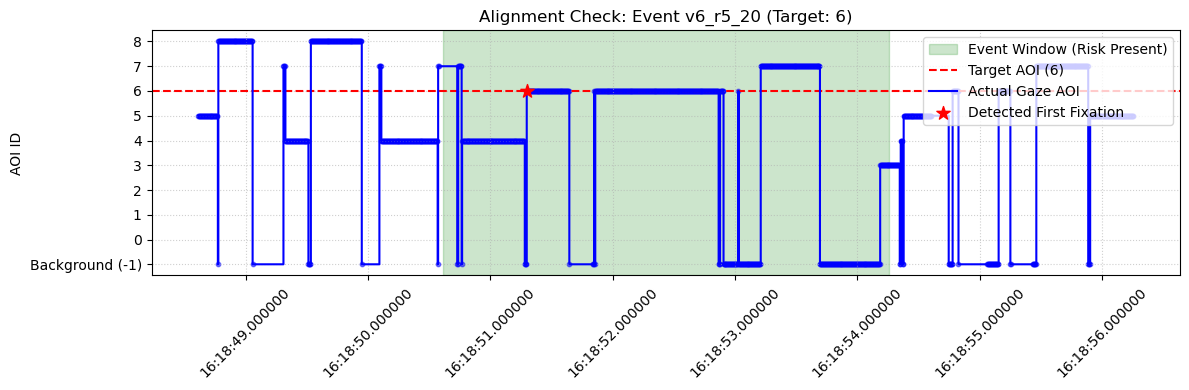

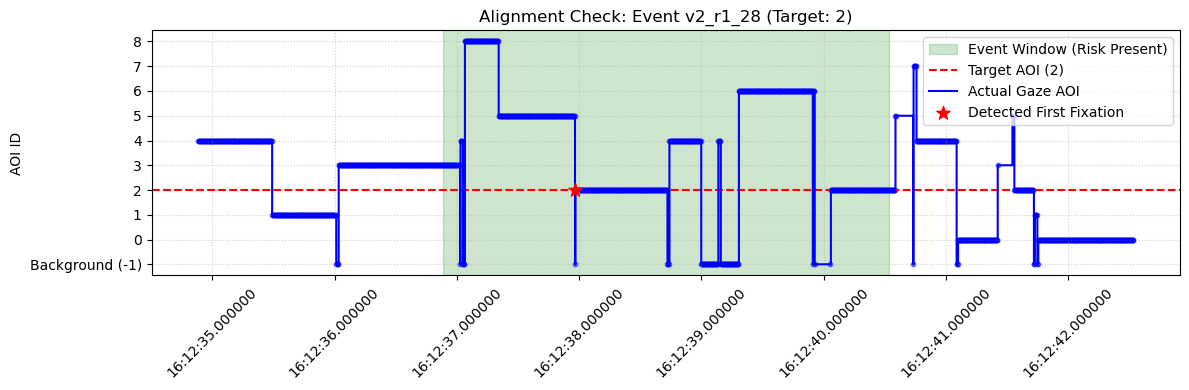

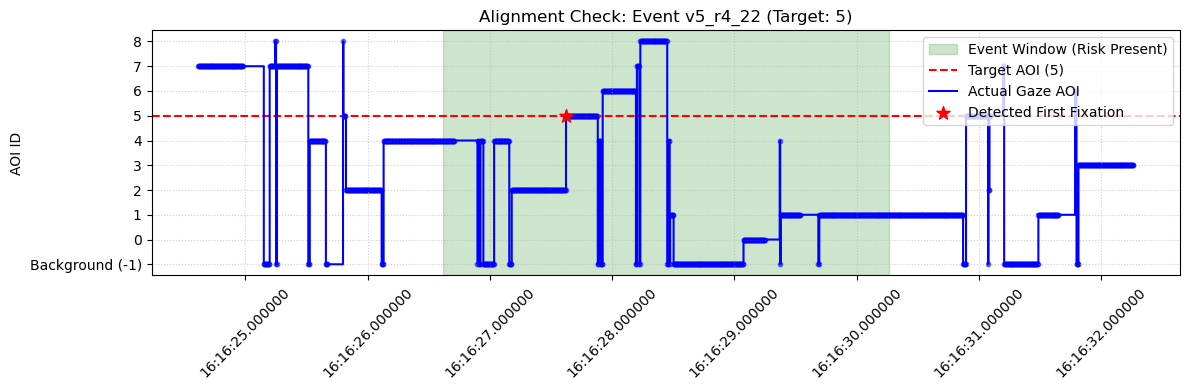

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import random

# --- 配置 ---
# 从结果中随机抽几个事件来看看 (或者你可以手动指定 event_uid)
sample_events = df_results.sample(3) # 随机抽3个
# 或者手动指定一个奇怪的事件（比如 TTFF 只有 0.3ms 的那个）
# sample_events = df_results[df_results['TTFF_ms'] < 5].head(3) 

def plot_event_alignment(event_row, df_fix, pad_seconds=2.0):
    """
    画出事件时间窗和前后的眼动数据
    pad_seconds: 前后多画几秒，方便看趋势
    """
    # 1. 获取事件信息
    uid = event_row['event_uid']
    target_aoi = event_row['target_aoi']
    start_time = event_row['event_start_time'] if 'event_start_time' in event_row else df_merged[df_merged['event_uid']==uid]['abs_start_time'].iloc[0]
    end_time = event_row['event_end_time'] if 'event_end_time' in event_row else df_merged[df_merged['event_uid']==uid]['abs_end_time'].iloc[0]
    
    # 2. 定义绘图的时间范围 (事件前后各加 pad_seconds 秒)
    plot_start = start_time - pd.Timedelta(seconds=pad_seconds)
    plot_end = end_time + pd.Timedelta(seconds=pad_seconds)
    
    # 3. 切片眼动数据
    mask = (df_fix['Time'] >= plot_start) & (df_fix['Time'] <= plot_end)
    df_slice = df_fix.loc[mask].copy()
    
    if df_slice.empty:
        print(f"事件 {uid}: 该时间段内无眼动数据")
        return

    # 4. 绘图
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # A. 画出事件的时间窗 (绿色背景区域)
    # converting datetime to matplotlib number format for axvspan
    ax.axvspan(start_time, end_time, color='green', alpha=0.2, label='Event Window (Risk Present)')
    
    # B. 画出目标 AOI 的参考线 (虚线)
    ax.axhline(y=target_aoi, color='red', linestyle='--', label=f'Target AOI ({target_aoi})')
    
    # C. 画出实际的眼动轨迹 (蓝色散点/线)
    # y轴是 AOI_Hit ID (-1 到 8)
    ax.step(df_slice['Time'], df_slice['AOI_Hit'], where='post', color='blue', linewidth=1.5, label='Actual Gaze AOI')
    ax.scatter(df_slice['Time'], df_slice['AOI_Hit'], color='blue', s=10, alpha=0.5)

    # D. 标记出计算出来的 "首次注视点" (如果有)
    # 逻辑：在绿色区域内，第一个等于 Target 的点
    in_window = df_slice[(df_slice['Time'] >= start_time) & (df_slice['Time'] <= end_time)]
    hits = in_window[in_window['AOI_Hit'] == target_aoi]
    if not hits.empty:
        first_hit = hits.iloc[0]
        ax.scatter(first_hit['Time'], first_hit['AOI_Hit'], color='red', s=100, marker='*', zorder=10, label='Detected First Fixation')
        
    # 格式化
    ax.set_yticks(range(-1, 9))
    ax.set_yticklabels(['Background (-1)', '0', '1', '2', '3', '4', '5', '6', '7', '8'])
    ax.set_ylabel('AOI ID')
    ax.set_title(f"Alignment Check: Event {uid} (Target: {target_aoi})")
    
    # X轴时间格式化
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'))
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 运行画图 ---
# 确保我们需要的时间列在 df_results 里，或者重新 merge 一下
# 这里简单的处理方法是：遍历刚才计算好的 df_results，去原始 events 表找时间
for index, row in sample_events.iterrows():
    # 为了拿到准确的时间，我们需要回溯到 df_merged (或者 current_subj_events)
    # 假设 event_uid 是唯一的
    original_event = current_subj_events[current_subj_events['event_uid'] == row['event_uid']].iloc[0]
    
    # 构造一个临时对象传给绘图函数
    plot_data = {
        'event_uid': row['event_uid'],
        'target_aoi': row['target_aoi'],
        'event_start_time': original_event['abs_start_time'],
        'event_end_time': original_event['abs_end_time']
    }
    
    plot_event_alignment(plot_data, df_fix)

处理文件: P06_Block-B_Fixation_clean.csv
修正后的 ID: 06, Block: B
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


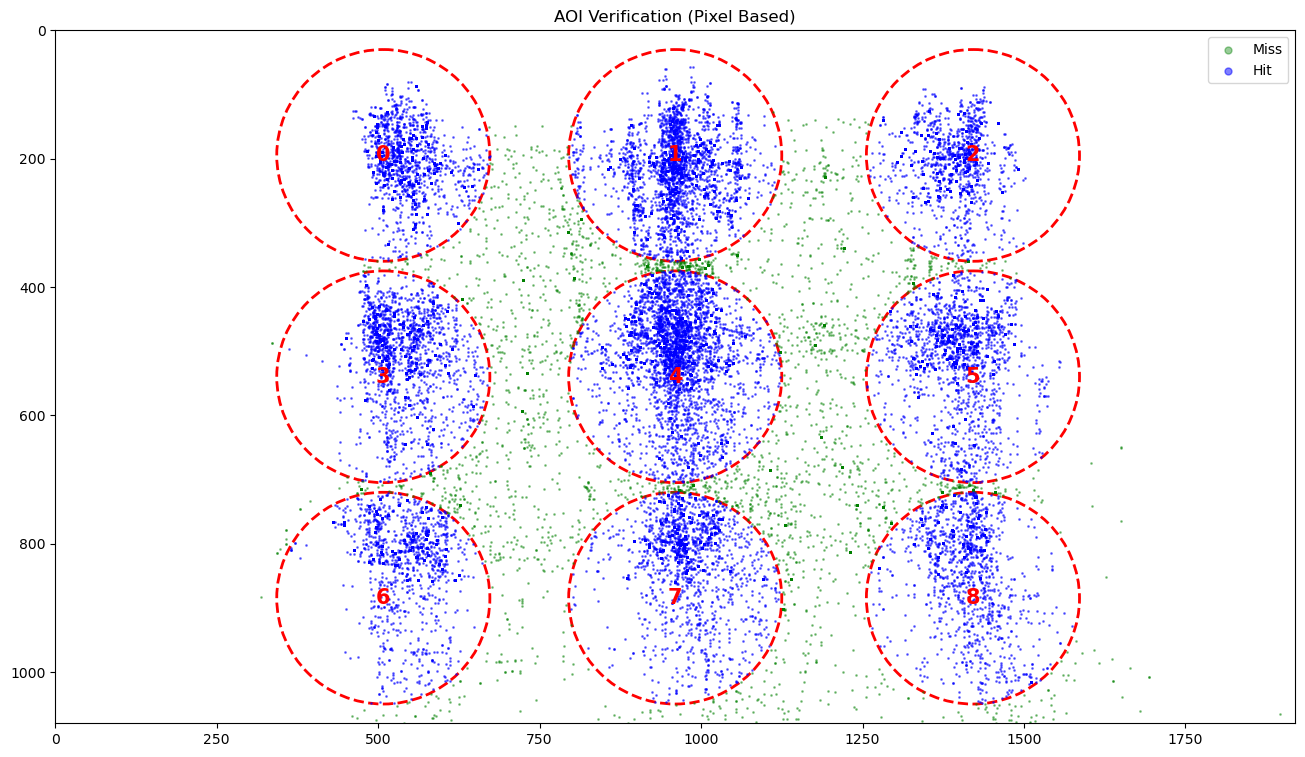

处理文件: P06_Block-C_Fixation_clean.csv
修正后的 ID: 06, Block: C
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


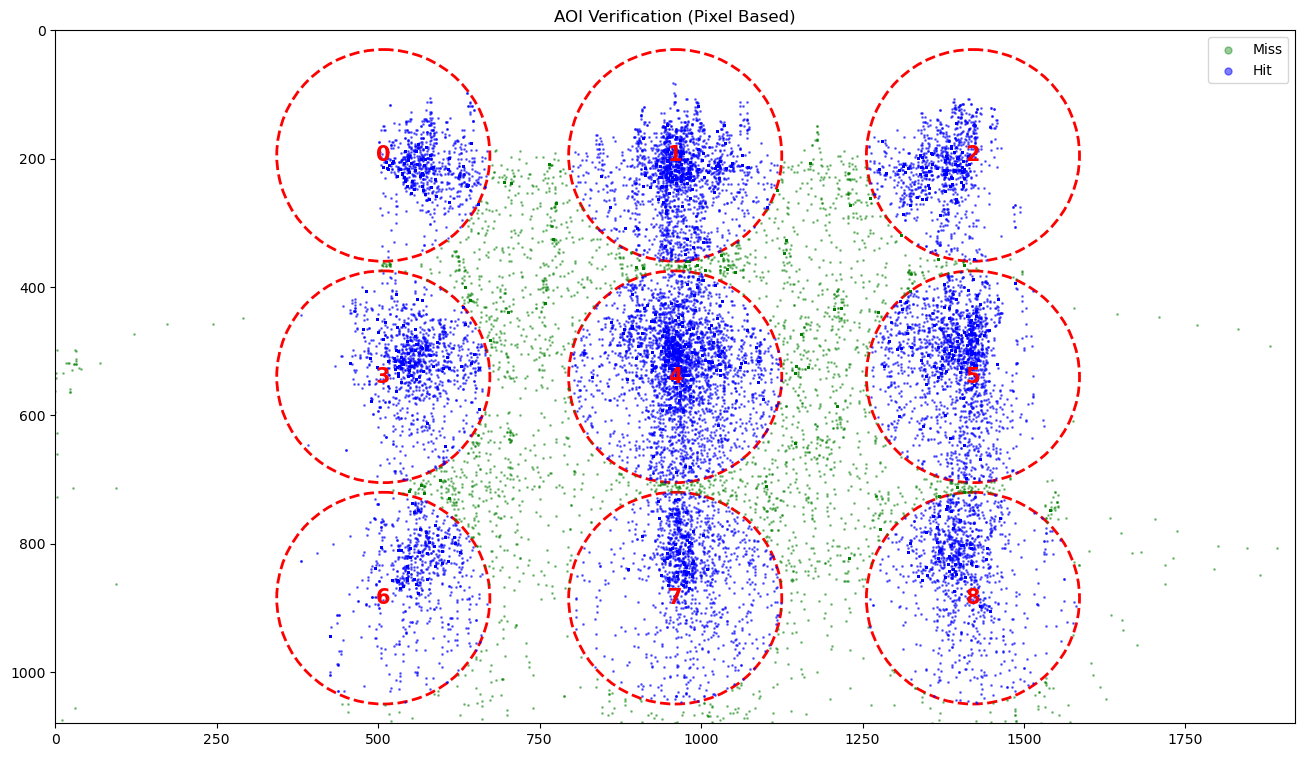

处理文件: P06_Block-D_Fixation_clean.csv
修正后的 ID: 06, Block: D
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


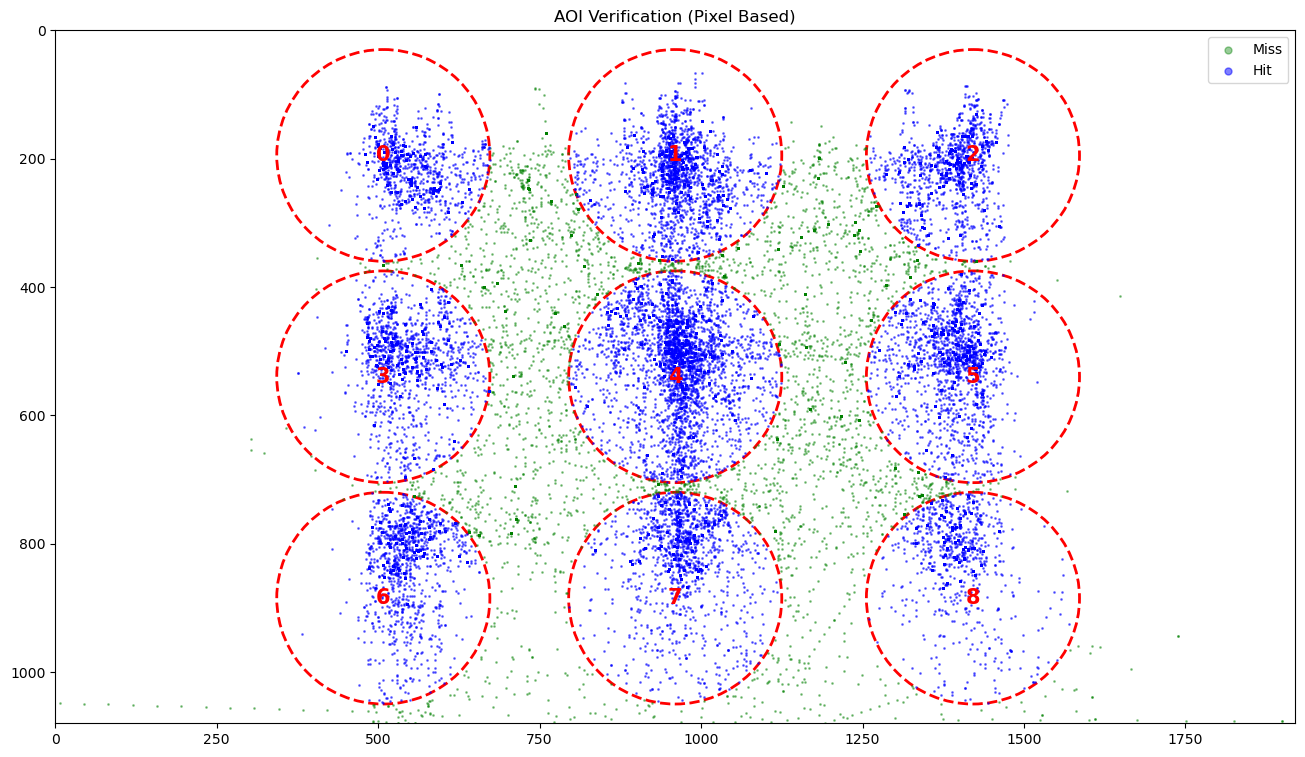

处理文件: P06_Block-E_Fixation_clean.csv
修正后的 ID: 06, Block: E
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


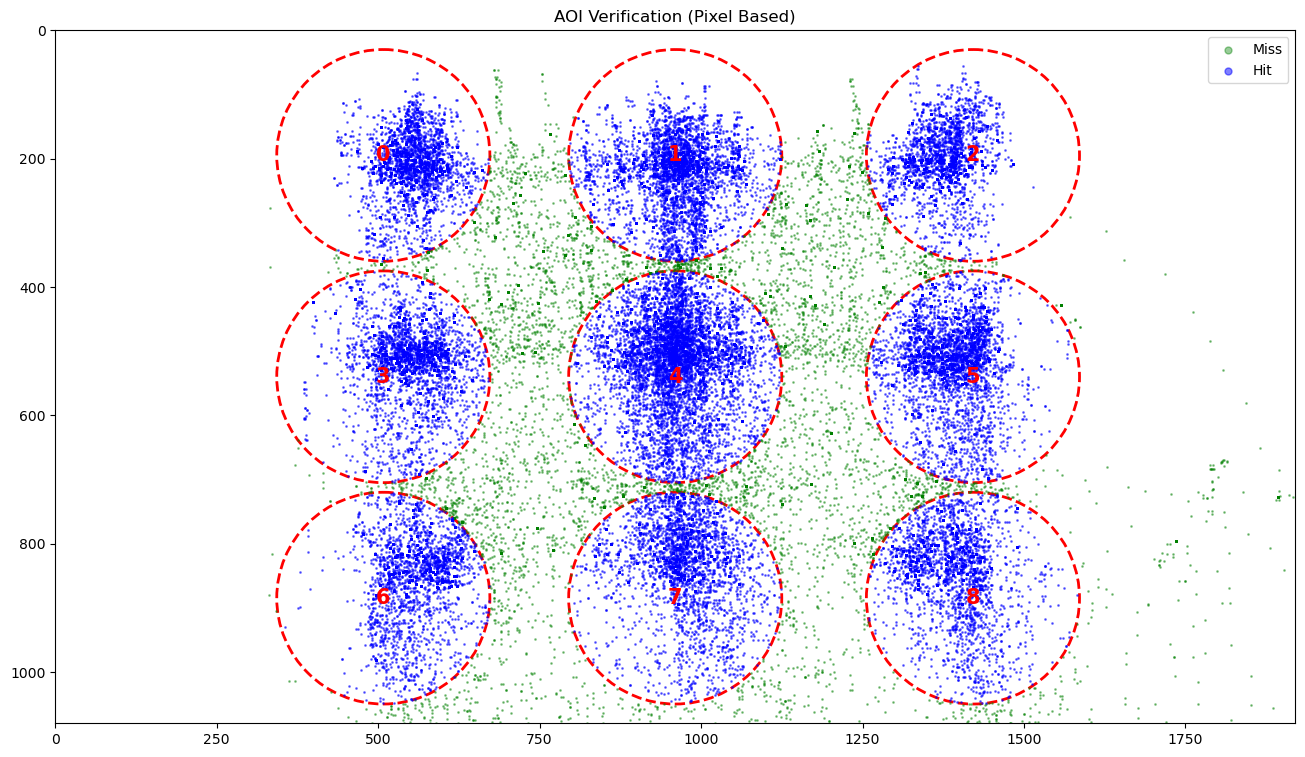

处理文件: P06_Block-F_Fixation_clean.csv
修正后的 ID: 06, Block: F
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


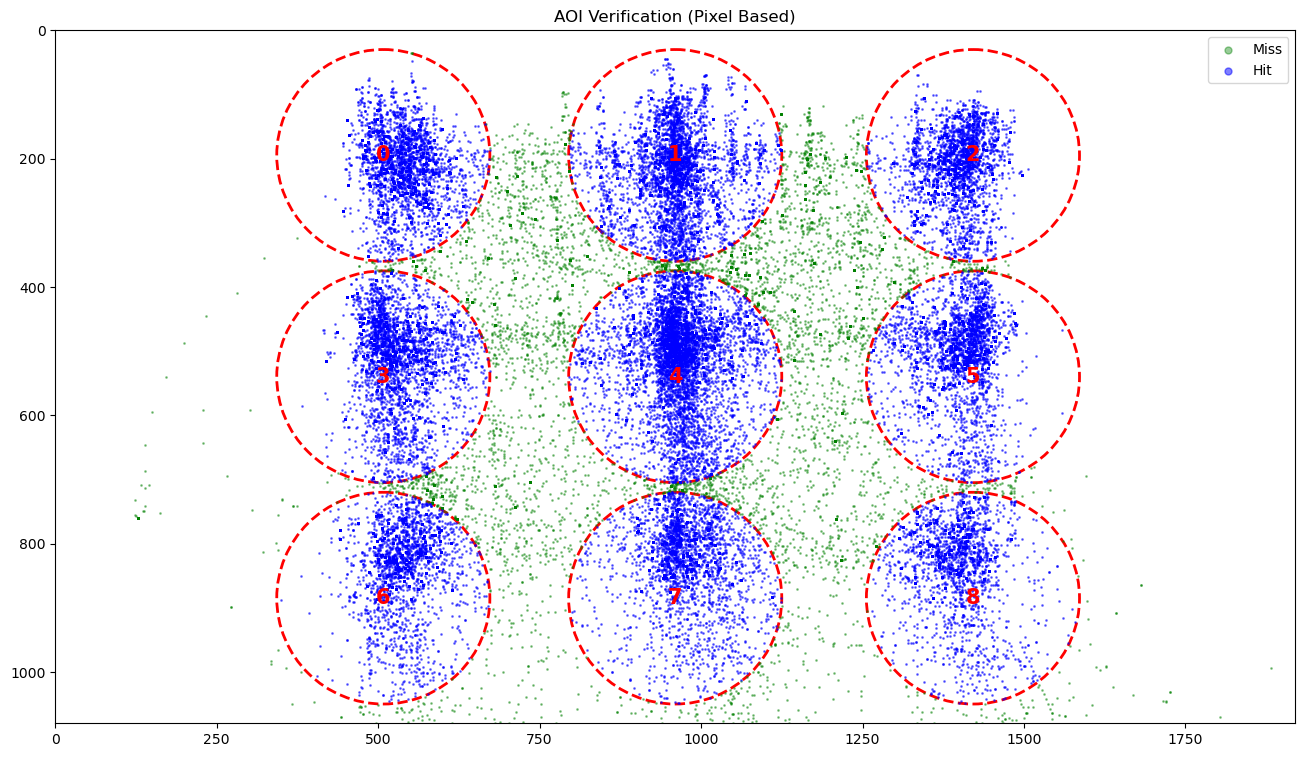

处理文件: P06_Block-G_Fixation_clean.csv
修正后的 ID: 06, Block: G
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


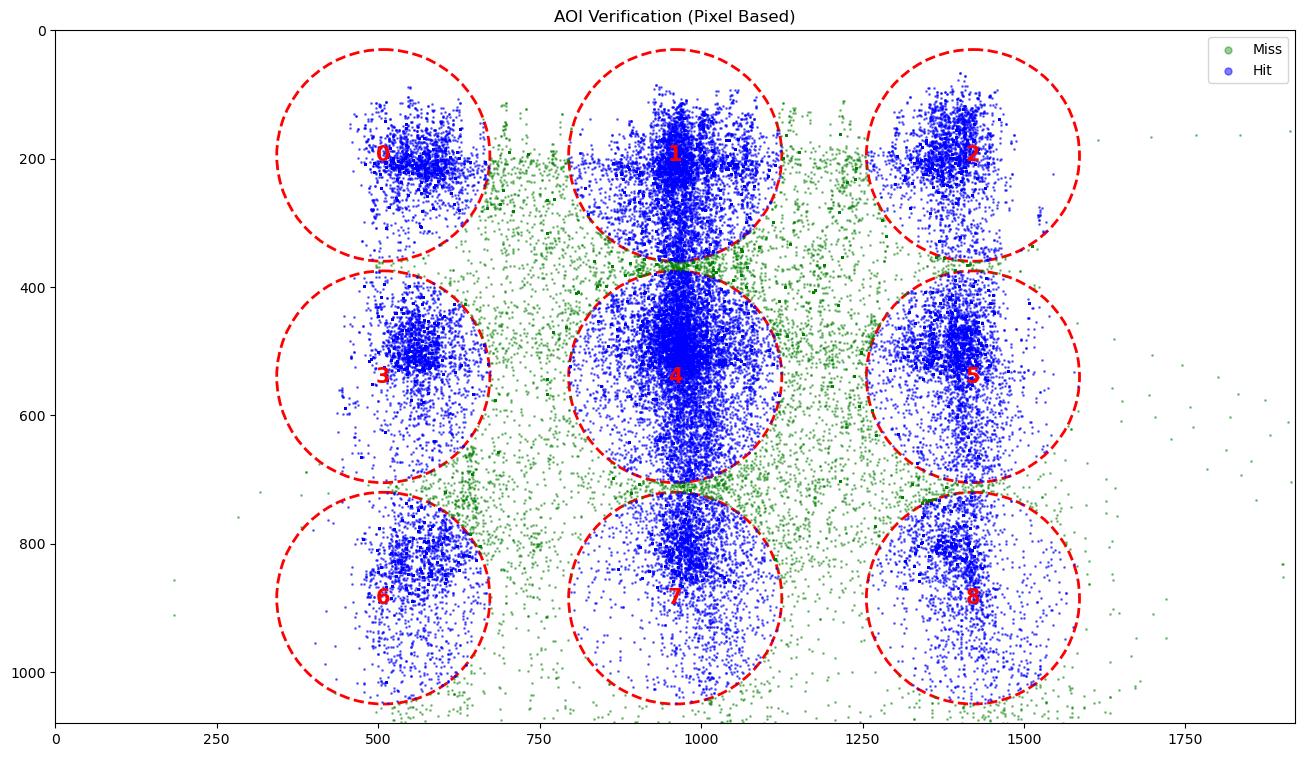

处理文件: P06_Block-H_Fixation_clean.csv
修正后的 ID: 06, Block: H
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


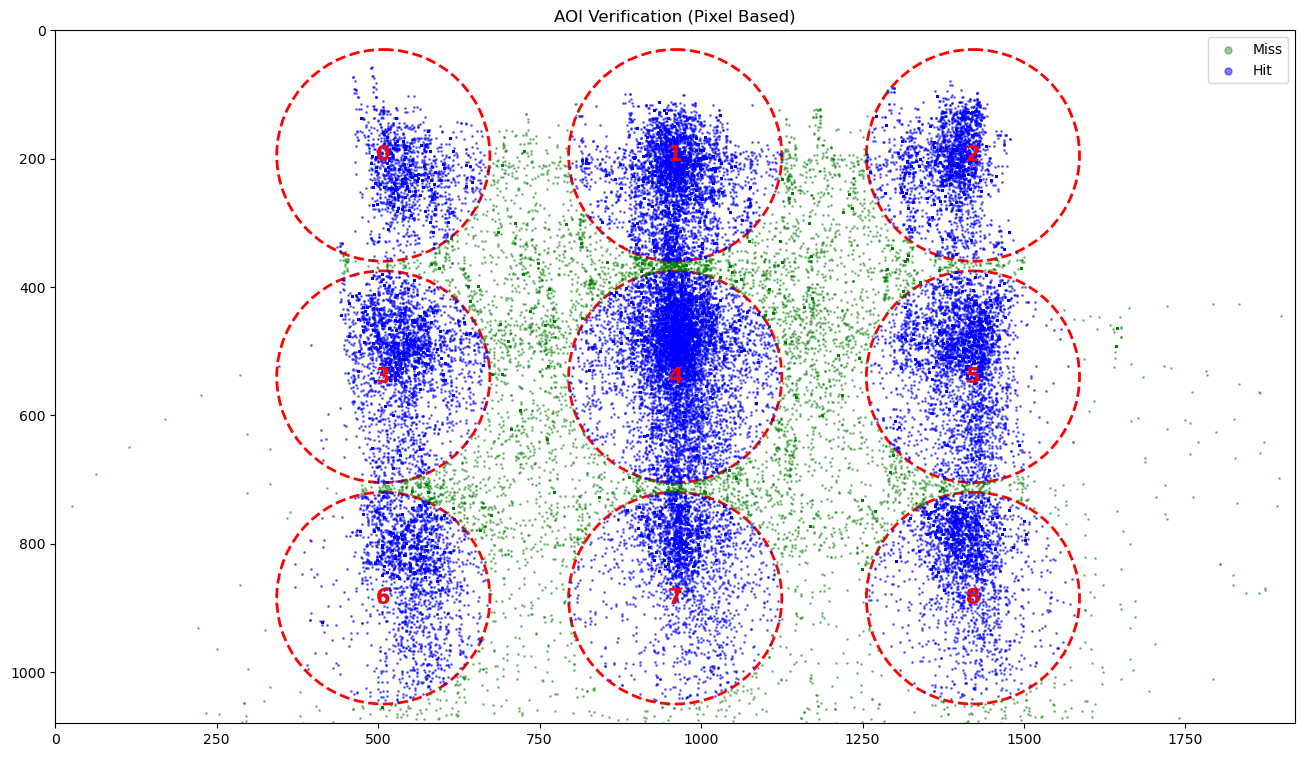

处理文件: P06_Block-full_Fixation_clean.csv
修正后的 ID: 06, Block: full
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


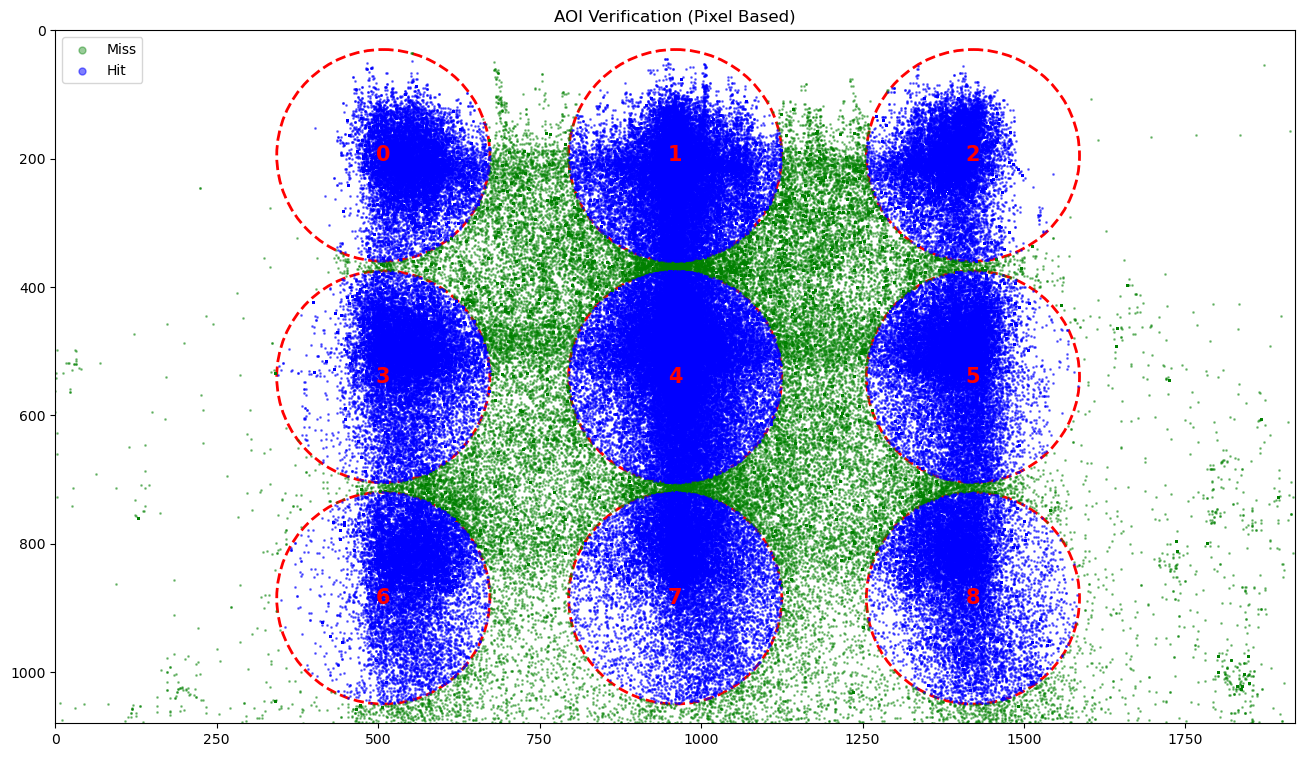

处理文件: P07_Block-A_Fixation_clean.csv
修正后的 ID: 07, Block: A
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


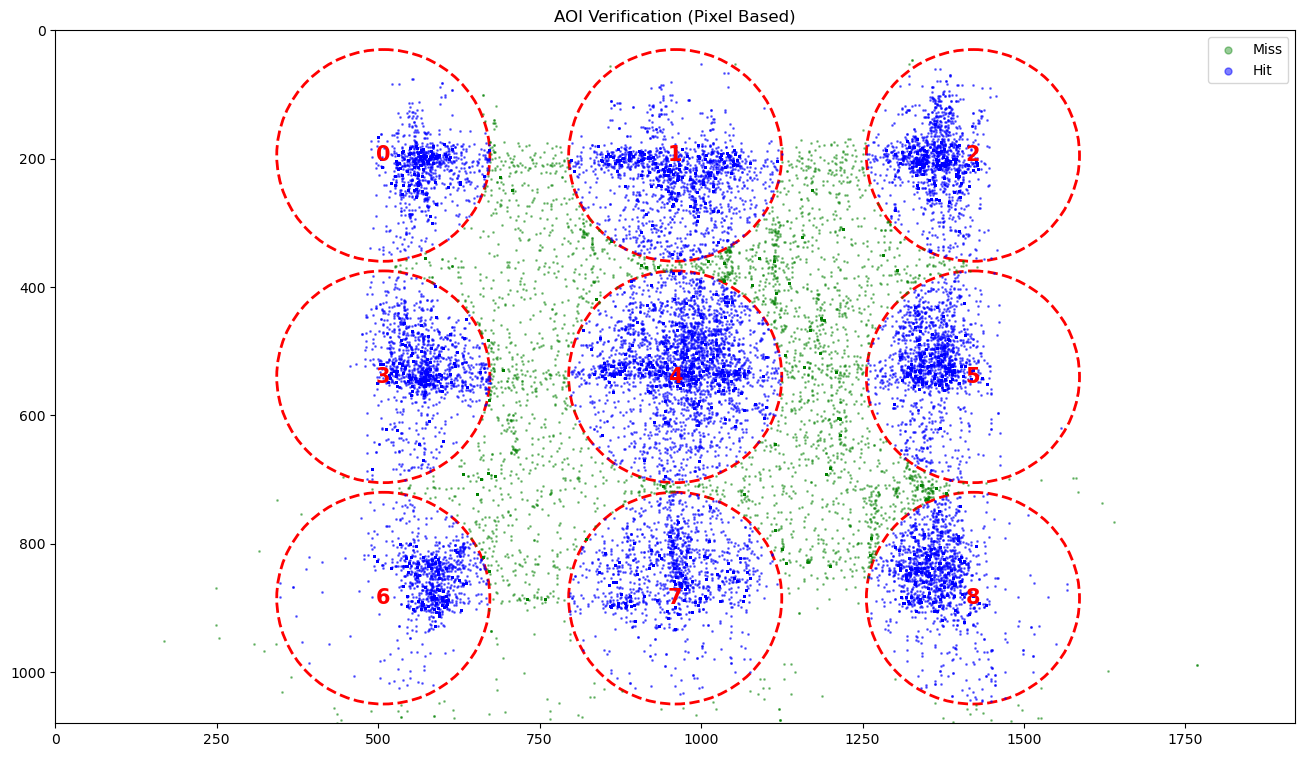

处理文件: P07_Block-B_Fixation_clean.csv
修正后的 ID: 07, Block: B
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


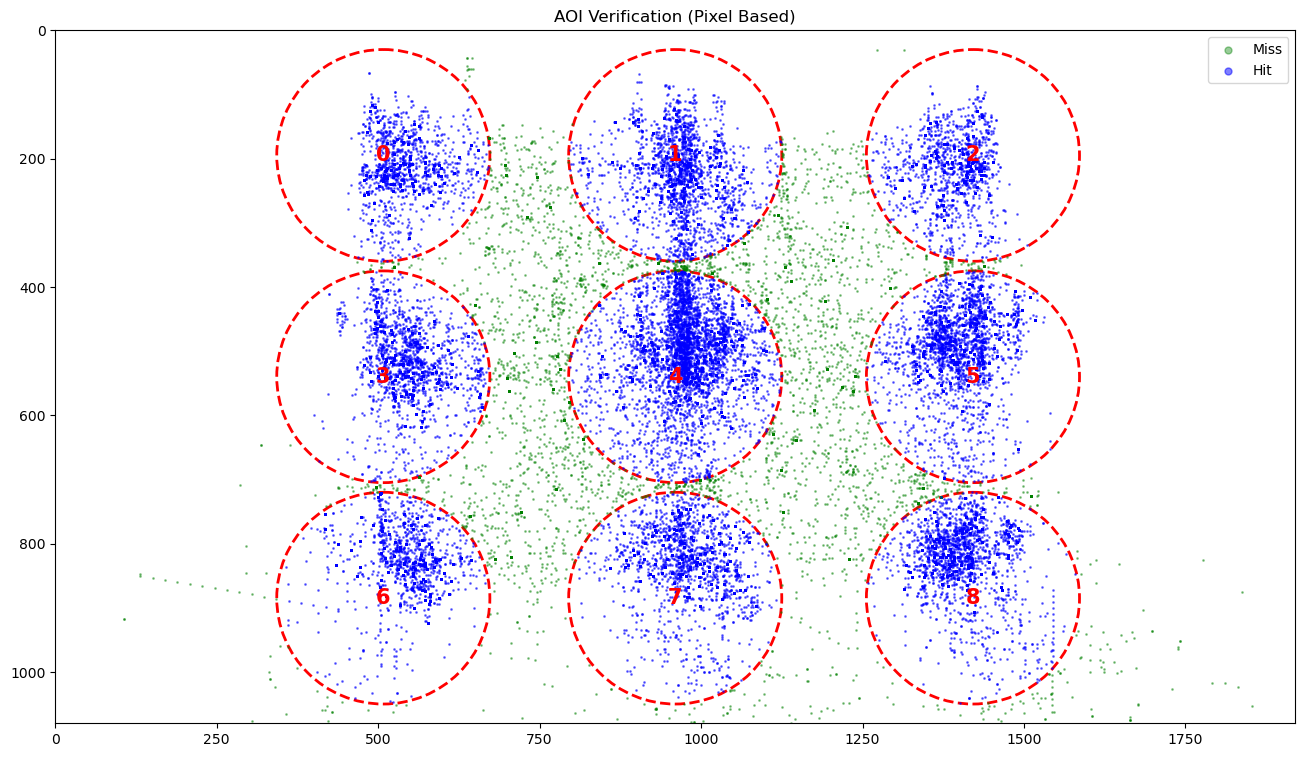

处理文件: P07_Block-C_Fixation_clean.csv
修正后的 ID: 07, Block: C
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


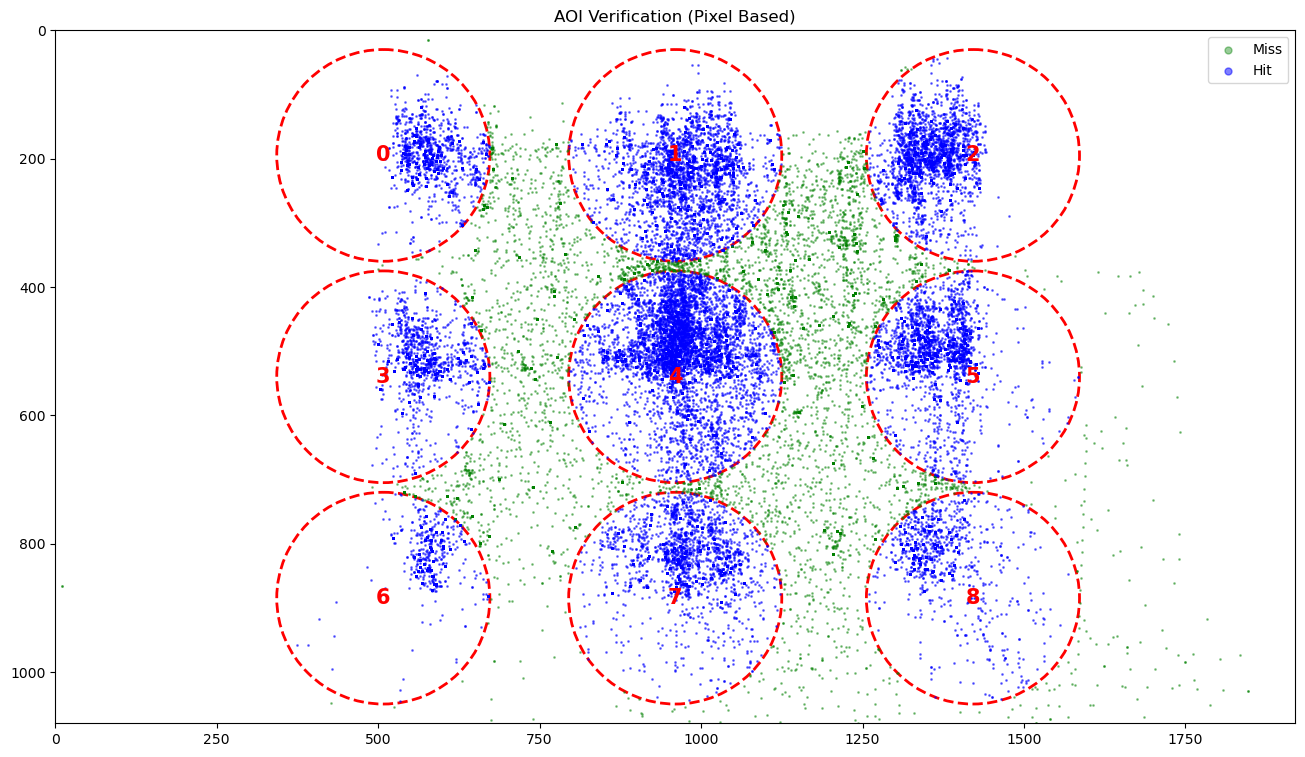

处理文件: P07_Block-D_Fixation_clean.csv
修正后的 ID: 07, Block: D
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


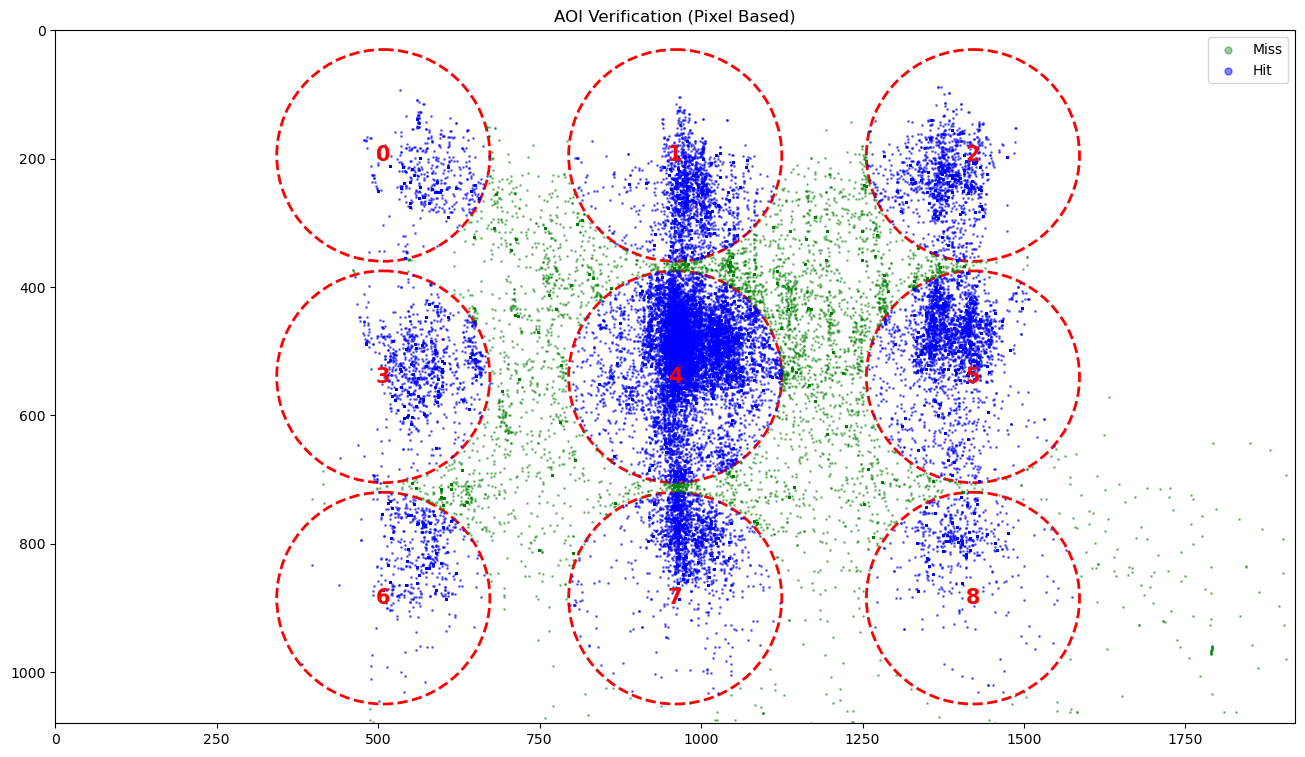

处理文件: P07_Block-E_Fixation_clean.csv
修正后的 ID: 07, Block: E
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


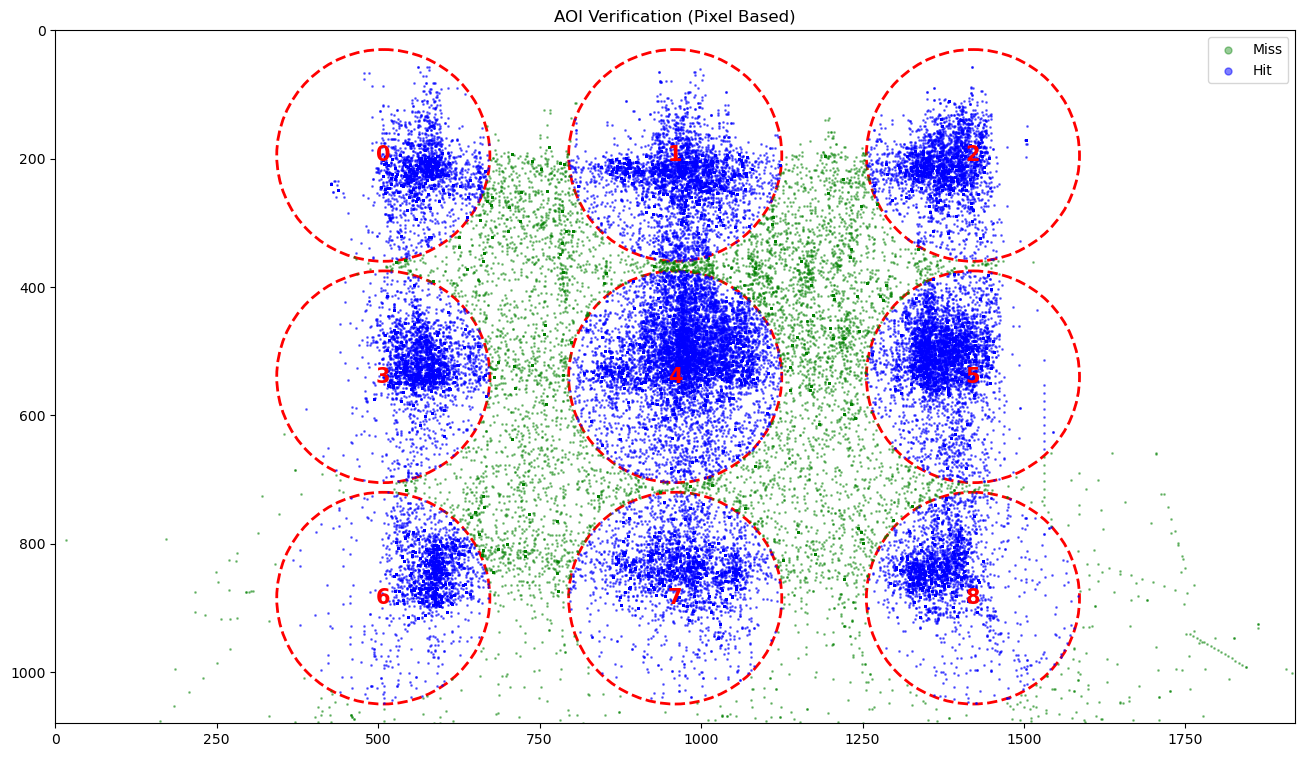

处理文件: P07_Block-F_Fixation_clean.csv
修正后的 ID: 07, Block: F
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


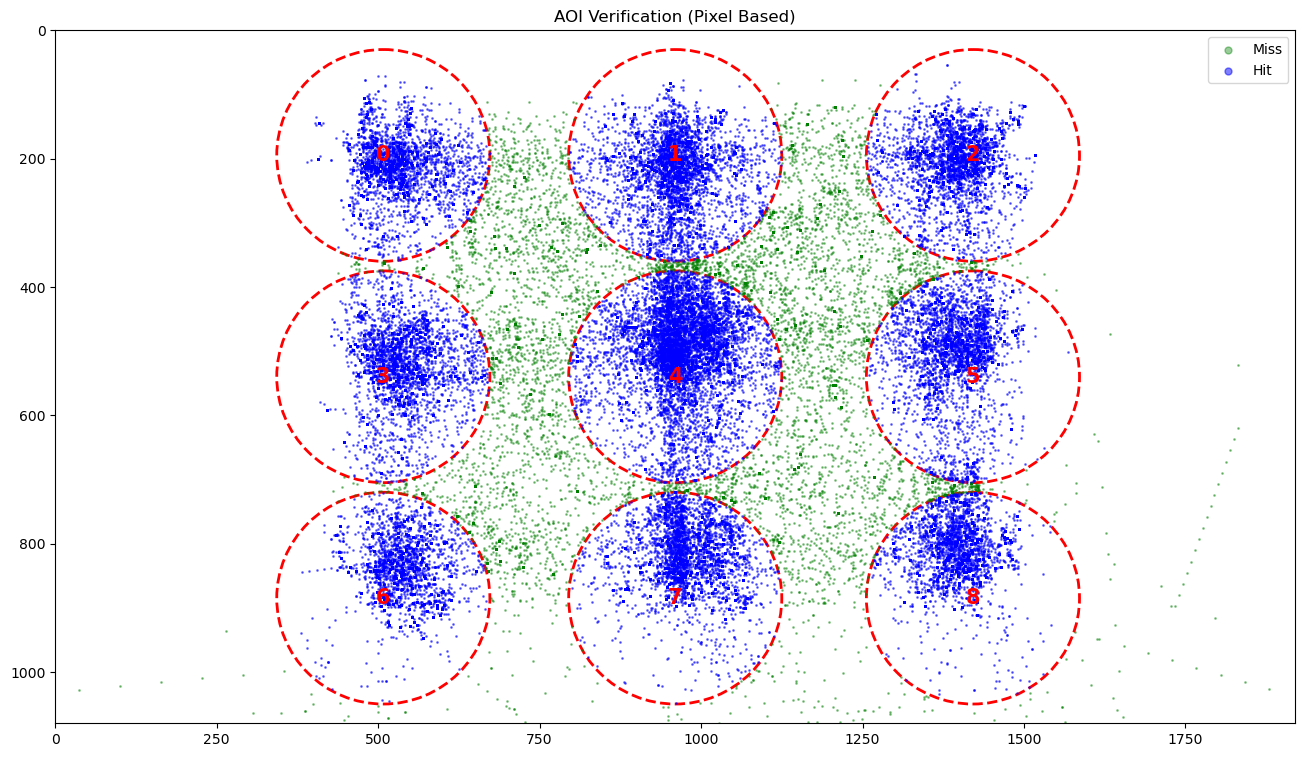

处理文件: P07_Block-G_Fixation_clean.csv
修正后的 ID: 07, Block: G
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


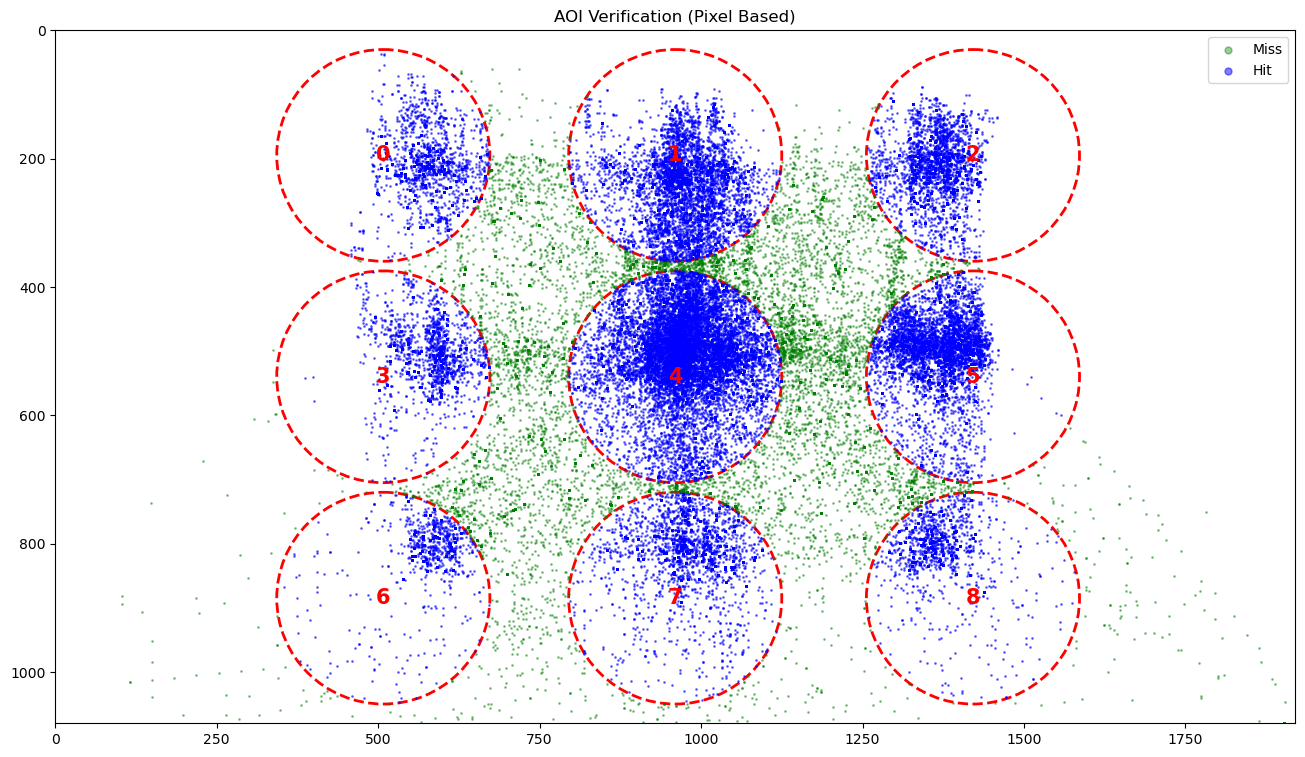

处理文件: P07_Block-H_Fixation_clean.csv
修正后的 ID: 07, Block: H
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


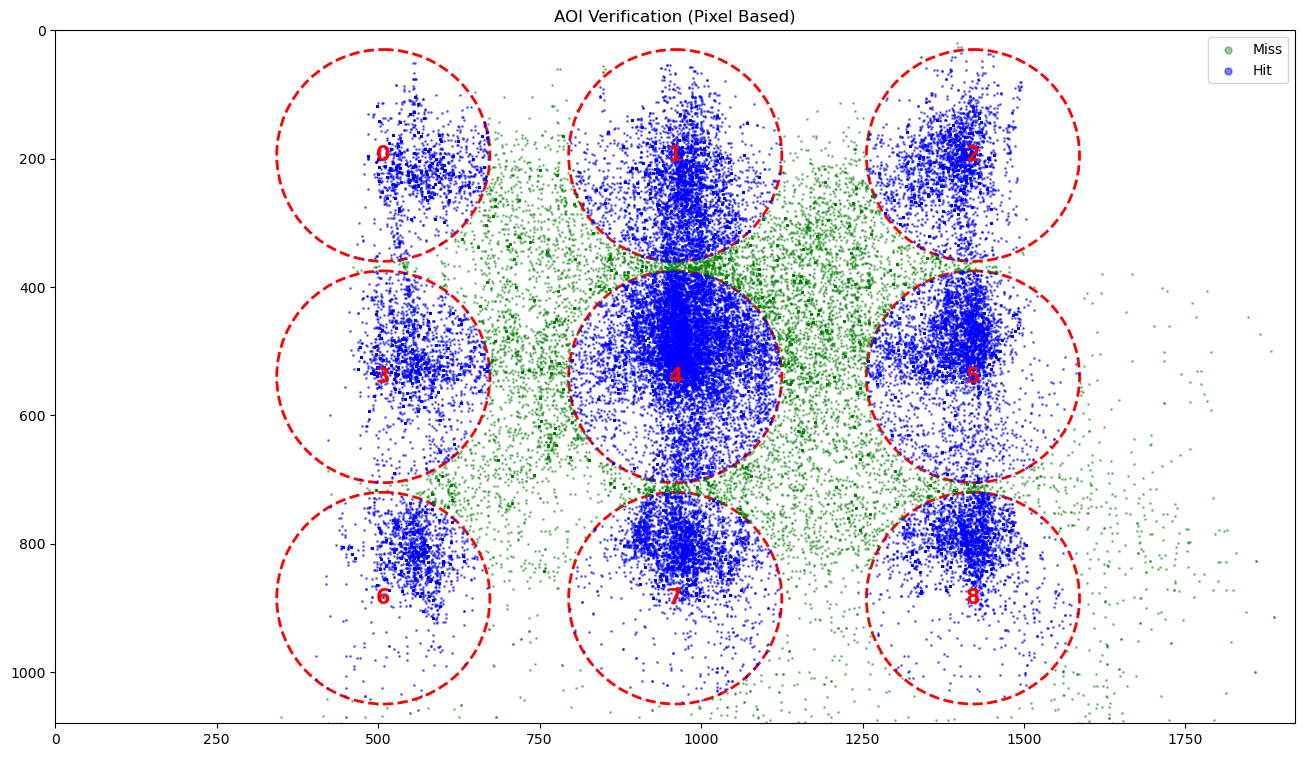

处理文件: P07_Block-full_Fixation_clean.csv
修正后的 ID: 07, Block: full
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


/Users/liyanyi/anaconda3/envs/remote_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


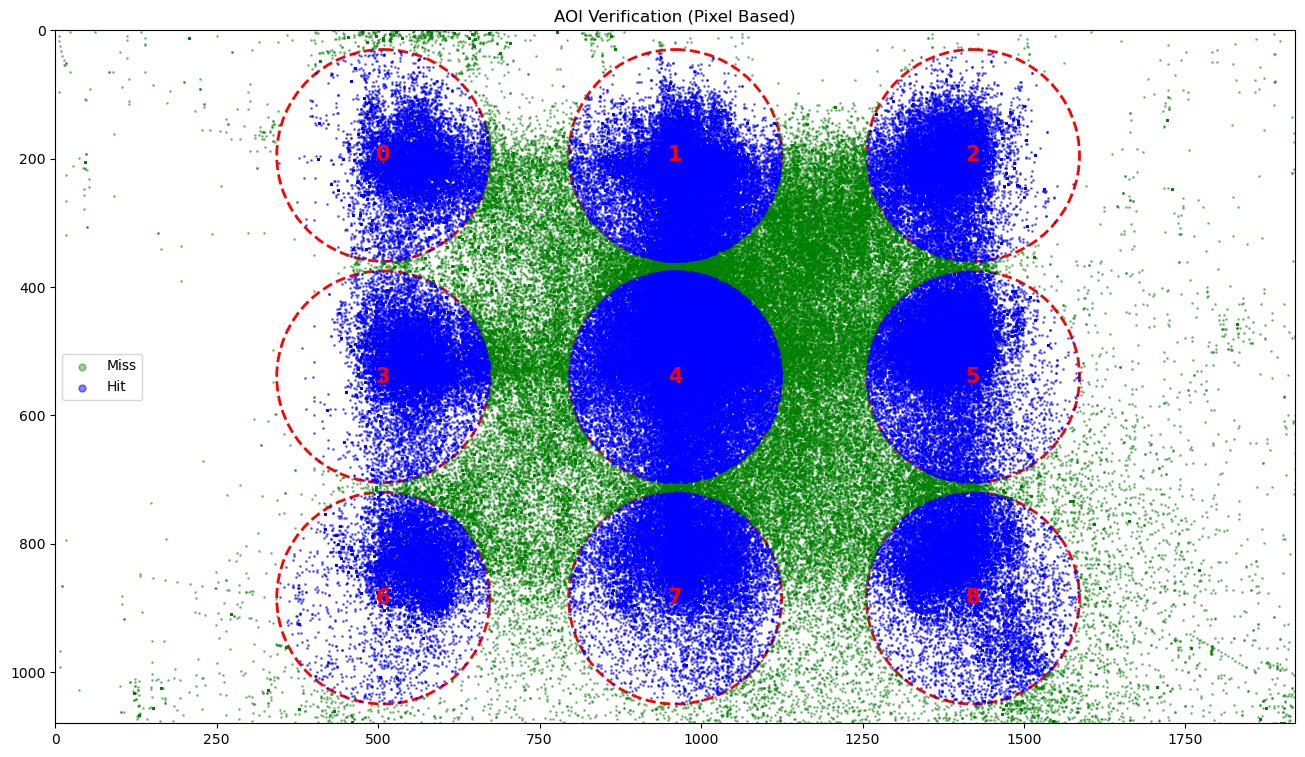

处理文件: P08_Block-A_Fixation_clean.csv
修正后的 ID: 08, Block: A
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


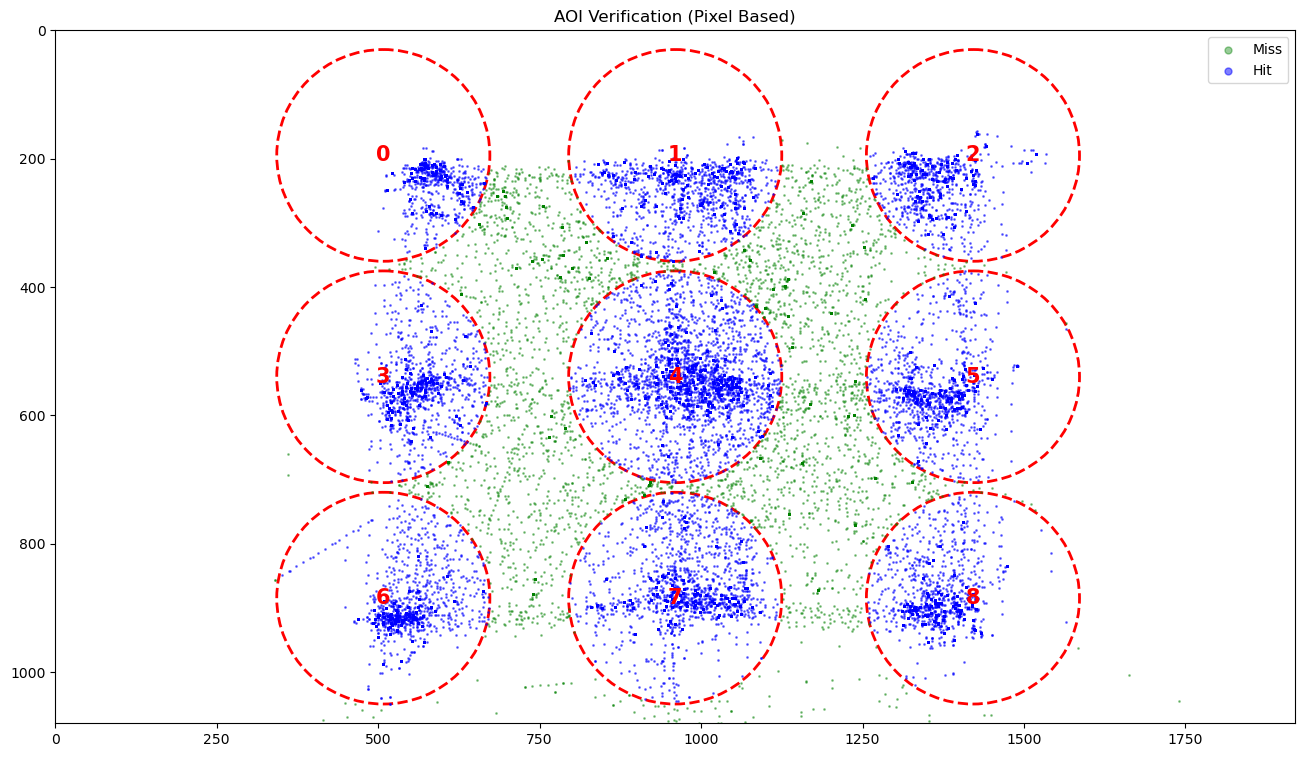

处理文件: P08_Block-B_Fixation_clean.csv
修正后的 ID: 08, Block: B
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


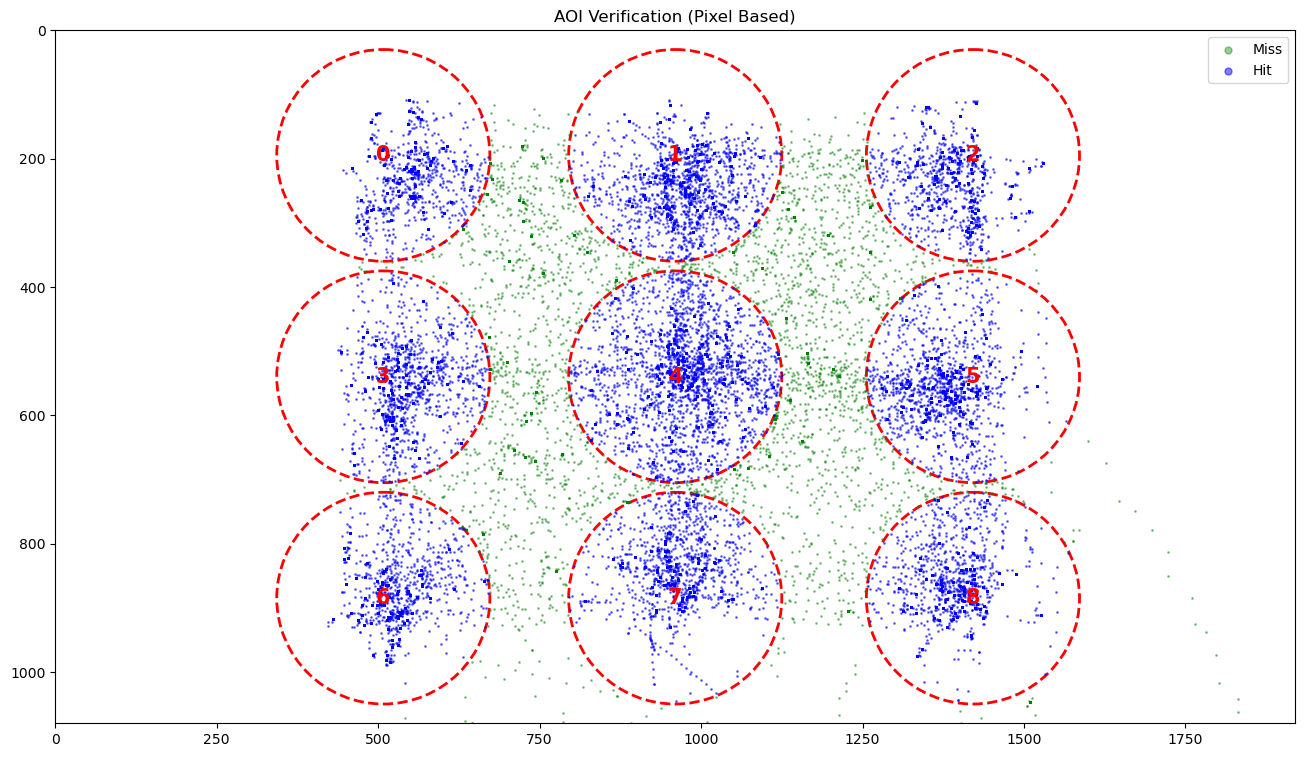

处理文件: P08_Block-C_Fixation_clean.csv
修正后的 ID: 08, Block: C
文件读取成功！
正在使用百分比坐标计算 AOI (含长宽比修正)...


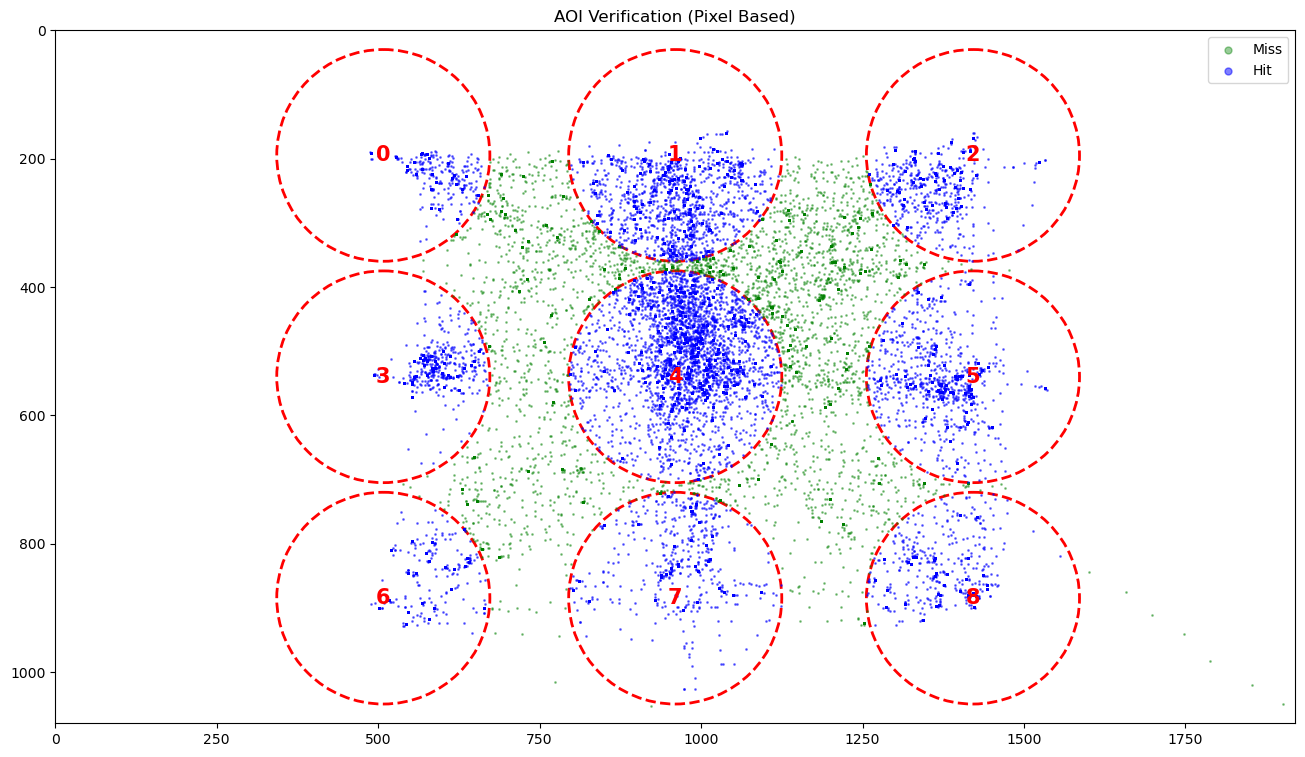

In [18]:
    # --- 1. 配置与读取 (保持你之前的逻辑) ---
for i in range(40,60):
    fix_dir = Path(raw_eye("汇总_FixationData_cleaned"))# 你的实际路径
    # 使用列表推导式过滤掉以 "." 开头的文件
    fix_files = [f for f in fix_dir.glob("*.csv") if not f.name.startswith(".")]

    target_file = fix_files[i] # 取第一个文件测试
    print(f"处理文件: {target_file.name}")

    # --- 2. 解析文件名并修正 ID ---
    file_name_parts = target_file.stem.split('_')
    subj_str = file_name_parts[0]   # "P01"
    block_str = file_name_parts[1]  # "Block-A"

    # 【修改点】: 去掉 'P'，并确保是两位数 (如果需要)
    # 逻辑: "P01".replace("P", "") -> "01"
    # 注意：你需要确认你的 events 表里 ID 是 "01"(字符串) 还是 1(数字)。这里先按字符串 "01" 处理。
    subj_id_clean = subj_str.replace("P", "") 

    if "Block-" in block_str:
        block_label = block_str.replace("Block-", "")
    else:
        block_label = block_str

    print(f"修正后的 ID: {subj_id_clean}, Block: {block_label}")


    # --- 3. 读取数据 ---
    # 添加 encoding='gbk' 来正确识别中文
    try:
        df_fix = pd.read_csv(target_file, encoding='utf-8')
    except UnicodeDecodeError:
        # 如果 gbk 还不行，尝试 gb18030 (gbk的超集)
        df_fix = pd.read_csv(target_file, encoding='gb18030')

    print("文件读取成功！")
    df_fix['participant_id'] = subj_id_clean
    df_fix['block_label'] = block_label
    df_fix['Time'] = pd.to_datetime(df_fix['Time'])

    # aoi_centers_pct = {
    #     0: (26.0, 17.5),  1: (50.0, 17.5),  2: (74.0, 17.5),
    #     3: (26.0, 47.5),  4: (50.0, 47.5),  5: (74.0, 47.5),
    #     6: (26.0, 77.5),  7: (50.0, 77.5),  8: (74.0, 77.5)
    # }
    # RADIUS_Y_PCT = 15.0
    # ASPECT_RATIO = 1920 / 1080

    # def get_aoi_label_pct(row):
    #     # 获取百分比坐标
    #     x_pct, y_pct = row['X(px)'], row['Y(px)']
        
    #     # 简单的异常值过滤 (如果在屏幕外)
    #     if pd.isna(x_pct) or pd.isna(y_pct):
    #         return -1
            
    #     for aoi_id, (cx, cy) in aoi_centers_pct.items():
    #         # --- 核心修正 ---
    #         # 计算距离时，把 X 轴的差异乘以长宽比，统一转化为 "Y轴单位"
    #         # 这样画出来的判定区域才是正圆，而不是扁的椭圆
    #         dx = (x_pct - cx) * ASPECT_RATIO
    #         dy = (y_pct - cy)
            
    #         distance = np.sqrt(dx**2 + dy**2)
            
    #         if distance <= RADIUS_Y_PCT:
    #             return aoi_id
                
    #     return -1
    aoi_centers_px = {
        0: (508, 195),   1: (960, 195),   2: (1421, 195),
        3: (508, 540),   4: (960, 540),   5: (1421, 540),
        6: (508, 885),   7: (960, 885),   8: (1421, 885)
    }
    # 注意：上面的数值是基于我们刚才调整好的百分比 (1920x1080分辨率) 推算的示例。
    # 如果你手头有确切的数值，请直接替换它们。

    RADIUS_PX = 165 

    # --- 2. 计算 AOI ---
    def get_aoi_label_px(row):
        # 使用像素列
        x, y = row['X(px)'], row['Y(px)']
        
        # 异常值过滤
        if pd.isna(x) or pd.isna(y):
            return -1
            
        for aoi_id, (cx, cy) in aoi_centers_px.items():
            # 像素坐标通常是 1:1 的，直接算欧几里得距离即可
            distance = np.sqrt((x - cx)**2 + (y - cy)**2)
            
            if distance <= RADIUS_PX:
                return aoi_id
                
        return -1

    print("正在使用百分比坐标计算 AOI (含长宽比修正)...")
    df_fix['AOI_Hit'] = df_fix.apply(get_aoi_label_px, axis=1)

    # --- 检查结果 ---
    # print("\nAOI 分布统计:")
    # print(df_fix['AOI_Hit'].value_counts())



    fig, ax = plt.subplots(figsize=(16, 9))

    # 绘制 AOI (红色圆形)
    for aoi_id, (cx, cy) in aoi_centers_px.items():
        # 像素模式下直接画圆
        circle = mpatches.Circle((cx, cy), RADIUS_PX, 
                                fill=False, edgecolor='red', linewidth=2, linestyle='--')
        ax.add_patch(circle)
        ax.text(cx, cy, str(aoi_id), color='red', fontsize=15, ha='center', va='center', fontweight='bold')

    # 绘制数据点
    hits = df_fix[df_fix['AOI_Hit'] != -1]
    misses = df_fix[df_fix['AOI_Hit'] == -1]

    # 没命中的点 (灰色)
    ax.scatter(misses['X(px)'], misses['Y(px)'], c='green', s=1, alpha=0.4, label='Miss')
    # 命中的点 (蓝色)
    ax.scatter(hits['X(px)'], hits['Y(px)'], c='blue', s=1, alpha=0.5, label='Hit')

    # 坐标轴设置
    # 假设屏幕分辨率是 1920x1080，如果不是请修改这里
    ax.set_xlim(0, 1920)
    ax.set_ylim(1080, 0) # 像素坐标 Y 轴向下增加，所以反转
    ax.set_title("AOI Verification (Pixel Based)")
    ax.legend(markerscale=5)

    plt.show()

In [ ]:
df_new = df_fix.sort_values(by = ['X(px)'])